In [1]:
#I am using my Python 3 11 scanorama env
! python --version

Python 3.11.9


In [2]:
import numpy as np
import pandas as pd

import scipy.sparse

import seaborn as sns

import math
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib import patches
from shapely.geometry import Polygon, MultiPolygon, Point

import scanpy as sc

import anndata as an
import scanorama

from pathlib import Path

import squidpy as sq

import geopandas as gpd

import os
import warnings

sc.logging.print_versions()

-----
anndata     0.10.7
scanpy      1.10.0
-----
PIL                         10.3.0
annoy                       NA
anyio                       NA
asciitree                   NA
asttokens                   NA
attr                        23.1.0
attrs                       23.1.0
babel                       2.11.0
brotli                      1.0.9
certifi                     2024.02.02
cffi                        1.16.0
charset_normalizer          2.0.4
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.1
cycler                      0.12.1
cython_runtime              NA
dask                        2024.5.0
dask_expr                   1.1.0
dask_image                  2023.08.1
datashader                  0.16.1
datatree                    0.0.14
dateutil                    2.8.2
debugpy                     1.6.7
decorator                   5.1.1
defusedxml                  0.7.1
docrep                      0.3.2
executing                  

In [3]:
warnings.simplefilter("ignore")

In [5]:
# Define the path to the .h5ad file
file_path = 'leidenclustering/VRT_A2a_A2b_leiden_200genes_res1_indexed.h5ad'

# Read the file into an AnnData object
adata_spatial = sc.read_h5ad(file_path)

# Print the object to confirm it has been loaded correctly
print(adata_spatial)

AnnData object with n_obs × n_vars = 50731 × 200
    obs: 'fov', 'volume', 'min_x', 'min_y', 'max_x', 'max_y', 'anisotropy', 'transcript_count', 'perimeter_area_ratio', 'solidity', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_150_genes', 'n_counts', 'dataset', 'clusters'
    uns: 'clusters', 'clusters_colors', 'hvg', 'neighbors', 'umap'
    obsm: 'X_scanorama', 'X_umap', 'blank_genes', 'spatial'
    obsp: 'connectivities', 'distances'


In [6]:
#Read in the cleaned/filtered adata objects for my samples
# Define the filenames of the saved AnnData objects
adata_filenames = {
    "adata_VGN1a6": "qc/adata_VGN1a6_clean.h5ad",
    "adata_VGN1a4": "qc/adata_VGN1a4_clean.h5ad"
}

# Initialize a dictionary to store the loaded AnnData objects
loaded_adata_objects = {}

# Load each file and store it in the dictionary
for name, filename in adata_filenames.items():
    loaded_adata_objects[name] = sc.read_h5ad(filename)
    print(f"Loaded {name} from {filename}")

# Access the loaded AnnData objects
adata_VGN1a6 = loaded_adata_objects["adata_VGN1a6"]
adata_VGN1a4 = loaded_adata_objects["adata_VGN1a4"]

Loaded adata_VGN1a6 from qc/adata_VGN1a6_clean.h5ad
Loaded adata_VGN1a4 from qc/adata_VGN1a4_clean.h5ad



VGN1e1 = late double ridge, VRT-A2a (P1 WT) <p>
VGN1e9 = late double ridge, VRT-A2b (P1 Pol) <p>
VGN1b6 = lemma primorida, VRT-A2a (P1 WT) <p>
VGN1b8 = lemma primorida, VRT-A2b (P1 Pol) <p>
VGN1a6 = terminal spikelet, VRT-A2a (P1 WT) <p>
VGN1a4 = terminal spikelet, VRT-A2b (P1 Pol) <p>
VGN1c2 = carpel extension round, VRT-A2a (P1 WT) <p>
VGN1c3 = carpel extension round, VRT-A2b (P1 Pol)


# Transect Plots Analysis of VRT-A2a (WT, W4) inflorescence 
Select the spike of terminal spikelet WT sample, then bin along the y axis and summate counts

In [75]:
segmentation_df = gpd.read_parquet('cell_segmentation/VGN1a_region6_output/cellpose2_micron_space_VGN1a6.parquet')

transcripts_df = pd.read_csv('cell_segmentation/VGN1a_region6_output/detected_transcripts.csv') 


In [76]:
# I want to just look at cells in the inflorescence, which I selected in the VizGen MERSCOPE Visualiser tool 
file_path = 'VRT2analysis/24_10_24_allcellsinspike_VGN1a6.csv'
# Read the CSV file
cellgroups = pd.read_csv(file_path, header=0, index_col=0)

cell_list = cellgroups.index.tolist()

len(cell_list)

4696

In [77]:
# Filter cells to only those in the inflorescence 

#first make the cell id labels a string
segmentation_df['EntityID'] = segmentation_df['EntityID'].astype(str)

# Ensure cell_id_list also contains strings
cell_list = list(map(str, cell_list))

# Filter segmentation based on cell_id_list
filtered_segmentation_df = segmentation_df[segmentation_df['EntityID'].isin(cell_list)]
filtered_segmentation_df

ID             EntityID  ZIndex  \
538      538  2305551000007100071       6   
529      529  2305551000007100071       0   
520      520  2305551000007100071       5   
511      511  2305551000007100071       1   
502      502  2305551000007100071       4   
...      ...                  ...     ...   
12713  12713  2305551000055100230       2   
12608  12608  2305551000055100230       3   
13133  13133  2305551000055100230       0   
13238  13238  2305551000055100230       6   
13028  13028  2305551000055100230       5   

                                                Geometry ParentType ParentID  \
538    MULTIPOLYGON (((563.092 5483.028, 563.336 5484...       None     None   
529    MULTIPOLYGON (((563.092 5483.028, 563.336 5484...       None     None   
520    MULTIPOLYGON (((563.092 5483.028, 563.336 5484...       None     None   
511    MULTIPOLYGON (((563.092 5483.028, 563.336 5484...       None     None   
502    MULTIPOLYGON (((563.092 5483.028, 563.336 5484...       None     None   
...                                                  ...        ...      ...   
12713  MULTIPOLYGON (((311.576 7442.294, 316.129 7442...       None     None   
12608  MULTIPOLYGON (((311.576 7442.294, 316.129 7442...       None     None   
13133  MULTIPOLYGON (((311.576 7442.294, 316.129 7442...       None     None   
13238  MULTIPOLYGON (((311.576 7442.294, 316.129 7442...       None     None   
13028  MULTIPOLYGON (((311.576 7442.294, 316.129 7442...       None     None   

       Type  ZLevel  Name  
538    cell    10.5  None  
529    cell     1.5  None  
520    cell     9.0  None  
511    cell     3.0  None  
502    cell     7.5  None  
...     ...     ...   ...  
12713  cell     4.5  None  
12608  cell     6.0  None  
13133  cell     1.5  None  
13238  cell    10.5  None  
13028  cell     9.0  None  

[32872 rows x 9 columns]

In [78]:
#now I want to line up the transcripts and segmentation polygons, so I will do this by a spatial join
#I will filter so that only those transcripts that fall within cells are in the transcripts df

# Ensure segmentation_df is a GeoDataFrame
segmentation_df = gpd.GeoDataFrame(segmentation_df, geometry='Geometry')

# Convert transcripts_df to GeoDataFrame
transcripts_gdf = gpd.GeoDataFrame(
    transcripts_df,
    geometry=gpd.points_from_xy(transcripts_df['global_x'], transcripts_df['global_y'])
)

# Perform spatial join and drop duplicate rows
filtered_transcripts_gdf = gpd.sjoin(
    transcripts_gdf,
    filtered_segmentation_df[['EntityID', 'Geometry']],
    how='inner',
    predicate='within'
)

# Remove unnecessary columns and duplicates
filtered_transcripts_df = (
    filtered_transcripts_gdf
    .drop(columns=['index_right', 'Unnamed: 0'], errors='ignore')  # Drop join-related columns
    .drop_duplicates()  # Remove duplicate rows
)

# Reset the index for clarity
filtered_transcripts_df.reset_index(drop=True, inplace=True)

# Display result
filtered_transcripts_df


barcode_id   global_x   global_y  global_z           x           y  \
0                5  243.08392  7421.1626       0.0   398.77707   190.46838   
1                5  332.03363  7432.6680       0.0  1222.38550   297.00000   
2                5  231.55200  7479.5660       0.0   292.00000   731.24036   
3                5  226.15201  7494.2590       0.0   242.00000   867.28830   
4                6  215.11497  7476.3150       0.0   139.80519   701.14014   
...            ...        ...        ...       ...         ...         ...   
512031         297  549.47375  5586.6284       6.0  1261.95010  1838.79740   
512032         298  555.38306  5562.3500       6.0  1316.66530  1614.00000   
512033         300  553.15120  5483.2940       6.0  1296.00000   882.00000   
512034         300  560.81915  5544.5864       6.0  1367.00000  1449.52270   
512035         303  577.88320  5477.8257       6.0  1525.00000   831.36520   

        fov                gene         transcript_id              cell_id  \
0       362  TraesCS4D02G243700  TraesCS4D02G243700_2  2305551000048100415   
1       362  TraesCS4D02G243700  TraesCS4D02G243700_2  2305551000055100206   
2       362  TraesCS4D02G243700  TraesCS4D02G243700_2  2305551000048100457   
3       362  TraesCS4D02G243700  TraesCS4D02G243700_2  2305551000048100464   
4       362  TraesCS1D02G127700  TraesCS1D02G127700_1  2305551000054100272   
...     ...                 ...                   ...                  ...   
512031  415  TraesCS2A02G505000  TraesCS2A02G505000_1  2305551000013100043   
512032  415  TraesCS6A02G410700  TraesCS6A02G410700_1  2305551000013100018   
512033  415             Blank-0                    -1  2305551000007100077   
512034  415             Blank-0                    -1  2305551000007100144   
512035  415             Blank-3                    -1  2305551000008100352   

                        geometry             EntityID  
0       POINT (243.084 7421.163)  2305551000048100415  
1       POINT (332.034 7432.668)  2305551000055100206  
2       POINT (231.552 7479.566)  2305551000048100457  
3       POINT (226.152 7494.259)  2305551000048100464  
4       POINT (215.115 7476.315)  2305551000054100272  
...                          ...                  ...  
512031  POINT (549.474 5586.628)  2305551000013100043  
512032  POINT (555.383 5562.350)  2305551000013100018  
512033  POINT (553.151 5483.294)  2305551000007100077  
512034  POINT (560.819 5544.586)  2305551000007100144  
512035  POINT (577.883 5477.826)  2305551000008100352  

[512036 rows x 12 columns]

### let's first look at the orientation of the spike 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


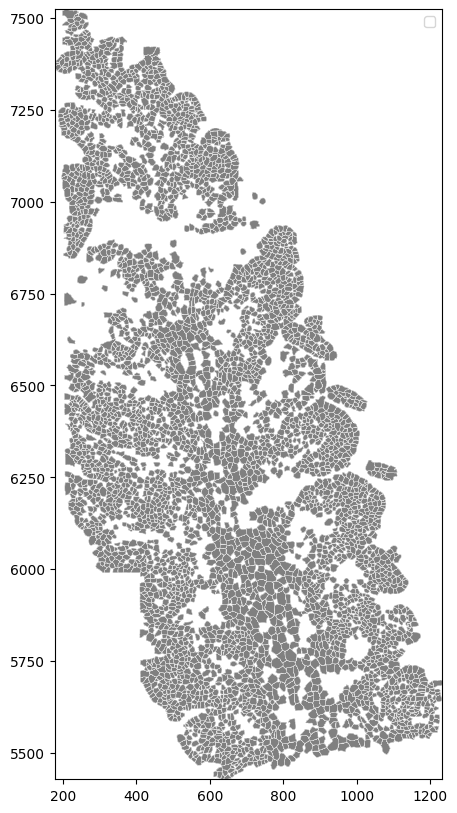

In [79]:
# Prepare a list of patches for plotting filtered segmentation cells
filtered_patches_list = []

# Add each filtered cell's polygon to the plot
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor="gray", edgecolor='white', linewidth=0.25)
            filtered_patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor="gray", edgecolor='white', linewidth=0.25)
        filtered_patches_list.append(patch)

# Calculate bounding box for the filtered segmentation cells
filtered_x_coords = [coord[0] for patch in filtered_patches_list for coord in patch.get_xy()]
filtered_y_coords = [coord[1] for patch in filtered_patches_list for coord in patch.get_xy()]
x_min, x_max = min(filtered_x_coords), max(filtered_x_coords)
y_min, y_max = min(filtered_y_coords), max(filtered_y_coords)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Add filtered segmentation polygons
collection = PatchCollection(filtered_patches_list, match_original=True)
ax.add_collection(collection)


# Set axis limits to focus on the area of interest
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_aspect('equal')

ax.legend()

plt.show()

### now I rotate the sample so it is in its desired orientation

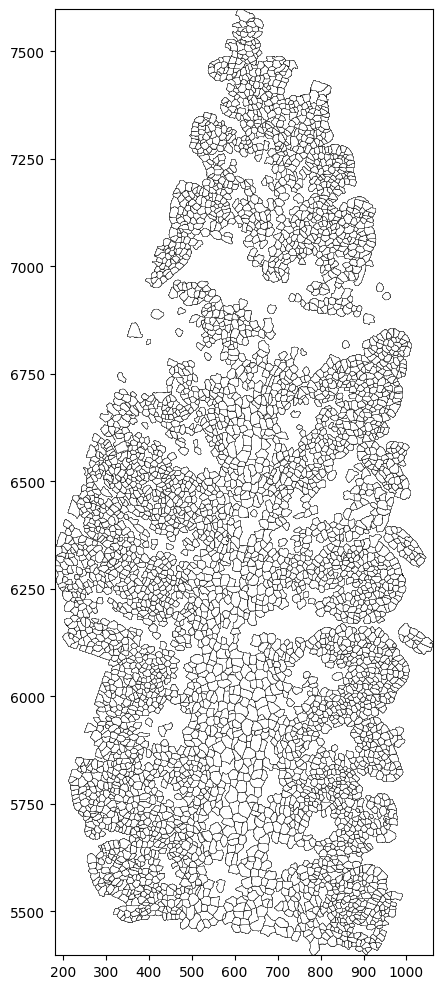

In [80]:
# Define rotation parameters
angle = 19  # Degrees
radians = math.radians(angle)
cos_angle = math.cos(radians)
sin_angle = math.sin(radians)
rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])

# Calculate the center of the filtered segmentation data for rotation
segmentation_center_x = filtered_segmentation_df['Geometry'].centroid.x.mean()
segmentation_center_y = filtered_segmentation_df['Geometry'].centroid.y.mean()

# Apply rotation to each Polygon in the filtered segmentation data
rotated_patches_list = []
rotated_polygons = []
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            centered_coords = np.array(poly.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
            rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
            rotated_poly = Polygon(rotated_coords)
            rotated_polygons.append(rotated_poly)
            patch = patches.Polygon(rotated_coords, closed=True, facecolor="white", edgecolor='black', linewidth=0.25)
            rotated_patches_list.append(patch)
    elif isinstance(shape, Polygon):
        centered_coords = np.array(shape.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
        rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
        rotated_poly = Polygon(rotated_coords)
        rotated_polygons.append(rotated_poly)
        patch = patches.Polygon(rotated_coords, closed=True, facecolor="white", edgecolor='black', linewidth=0.25)
        rotated_patches_list.append(patch)

# Plot the rotated polygons
fig, ax = plt.subplots(figsize=(10, 10))

# Add rotated polygons
collection = PatchCollection(rotated_patches_list, match_original=True)
ax.add_collection(collection)

# Calculate axis limits
rotated_x_coords = [coord[0] for patch in rotated_patches_list for coord in patch.get_xy()]
rotated_y_coords = [coord[1] for patch in rotated_patches_list for coord in patch.get_xy()]
x_min, x_max = min(rotated_x_coords), max(rotated_x_coords)
y_min, y_max = min(rotated_y_coords), max(rotated_y_coords)

# Set axis limits
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_aspect('equal')


plt.tight_layout()
plt.show()


Now I want to display transcripts on the plot, draw on 25 transverse bins, and assign cells to bins

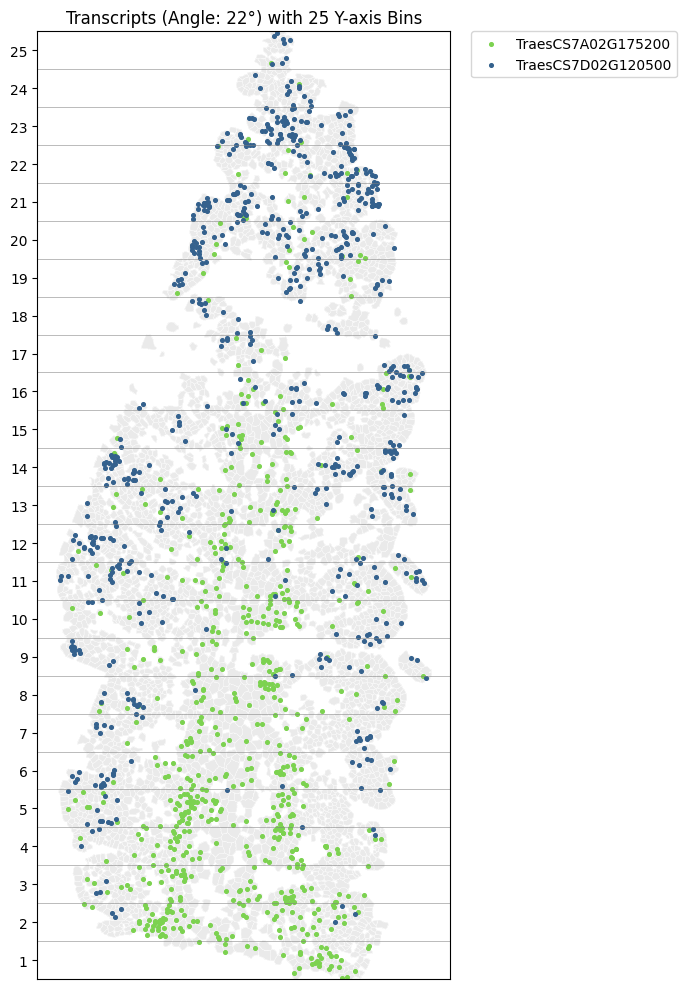

                 EntityID  Y_Bin
0     2305551000007100071    2.0
1     2305551000007100077    3.0
2     2305551000007100085    3.0
3     2305551000007100086    3.0
4     2305551000007100092    3.0
...                   ...    ...
4698  2305551000055100193   23.0
4699  2305551000055100206   24.0
4700  2305551000055100217   24.0
4701  2305551000055100230   24.0
4702  2305551000055100230   23.0

[4703 rows x 2 columns]


In [81]:
transcripts_in_area = filtered_transcripts_df.copy()

# Define genes and colors
genes_of_interest = {
    'TraesCS7A02G175200': '#7CD250',  # vRT2
    'TraesCS7D02G120500': '#34618D',  # SEP1-4
}

# Define rotation parameters
angle = 22 # Degrees
radians = math.radians(angle)
cos_angle = math.cos(radians)
sin_angle = math.sin(radians)
rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])

# Calculate the center of the filtered segmentation data for rotation
segmentation_center_x = filtered_segmentation_df['Geometry'].centroid.x.mean()
segmentation_center_y = filtered_segmentation_df['Geometry'].centroid.y.mean()

# Apply rotation to each Polygon in the filtered segmentation data
rotated_patches_list = []
rotated_polygons = []  # Store rotated polygons for containment checks
rotated_centroids = []  # Store centroids of rotated polygons for bin assignment
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            centered_coords = np.array(poly.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
            rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
            rotated_poly = Polygon(rotated_coords)
            rotated_polygons.append(rotated_poly)
            rotated_centroids.append(rotated_poly.centroid)
            patch = patches.Polygon(rotated_coords, closed=True, facecolor="#EAEAEA", edgecolor='white', linewidth=0.25)
            rotated_patches_list.append(patch)
    elif isinstance(shape, Polygon):
        centered_coords = np.array(shape.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
        rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
        rotated_poly = Polygon(rotated_coords)
        rotated_polygons.append(rotated_poly)
        rotated_centroids.append(rotated_poly.centroid)
        patch = patches.Polygon(rotated_coords, closed=True, facecolor="#EAEAEA", edgecolor='white', linewidth=0.25)
        rotated_patches_list.append(patch)

# Apply rotation to transcript coordinates
rotated_transcript_data = {}
for gene, color in genes_of_interest.items():
    transcripts_of_interest = transcripts_in_area[transcripts_in_area['gene'] == gene].copy()
    transcript_coords = transcripts_of_interest[['global_x', 'global_y']].to_numpy()
    centered_transcript_coords = transcript_coords - np.array([segmentation_center_x, segmentation_center_y])
    rotated_transcript_coords = np.dot(centered_transcript_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
    
    # Add rotated transcript coordinates for plotting
    rotated_transcript_data[gene] = {
        'x': rotated_transcript_coords[:, 0],
        'y': rotated_transcript_coords[:, 1],
        'color': color
    }

# Define bins along the Y-axis
rotated_y_coords = [centroid.y for centroid in rotated_centroids]
y_min, y_max = min(rotated_y_coords), max(rotated_y_coords)
num_bins = 25
y_bins = np.linspace(y_min, y_max, num_bins + 1)
y_bin_labels = list(range(1, num_bins + 1))  # Use simple numeric labels

# Assign Y-bin labels to each cell based on its rotated centroid's Y-coordinate
def assign_y_bin_to_cell(y_coord):
    """Assign Y-bin label based on the Y coordinate."""
    for i in range(len(y_bins) - 1):
        if y_bins[i] <= y_coord < y_bins[i + 1]:
            return y_bin_labels[i]  # Return numeric bin label
    return None

# Create a DataFrame with EntityID and Y-bin assignment
rotated_entity_bins = [
    {'EntityID': row.EntityID, 'Y_Bin': assign_y_bin_to_cell(centroid.y)}
    for row, centroid in zip(filtered_segmentation_df.itertuples(), rotated_centroids)
]

rotated_entity_bins_df = pd.DataFrame(rotated_entity_bins)

# Remove duplicates and reset index
rotated_entity_bins_df = rotated_entity_bins_df.drop_duplicates().reset_index(drop=True)

# Plot the rotated segmentation and transcripts
fig, ax = plt.subplots(figsize=(10, 10))

# Add rotated segmentation polygons
collection = PatchCollection(rotated_patches_list, match_original=True)
ax.add_collection(collection)

# Plot each gene's filtered transcripts with unique colors
for gene, data in rotated_transcript_data.items():
    ax.scatter(data['x'], data['y'], color=data['color'], s=7, alpha=1, label=gene)

# Draw Y-bin grid lines on the plot
for y_bin in y_bins:
    ax.axhline(y=y_bin, color='gray', linewidth=0.5, alpha=0.75, zorder=1)

# Set axis limits
ax.set_ylim([y_min, y_max])
ax.set_aspect('equal')

# Add custom Y-axis tick labels
bin_centers = (y_bins[:-1] + y_bins[1:]) / 2  # Calculate bin centers
plt.yticks(bin_centers, y_bin_labels)  # Replace y-axis ticks with numeric bin labels
plt.xticks([])
# Add title
ax.set_title(f"Transcripts (Angle: {angle}°) with 25 Y-axis Bins")

# Place the legend outside the plot
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0)

plt.tight_layout()
plt.show()

# Display the cleaned DataFrame
print(rotated_entity_bins_df)



now that I have the cells and their assigned bins, I want to extract the normalised counts
I do this because the counts per cell are normalised to account for heterogeneity across the sample
I will get this from the cleaned adata object I saved from previous analysis 

In [82]:
if isinstance(adata_VGN1a6.X, scipy.sparse.spmatrix):
    X_dense = adata_VGN1a6.X.toarray()
else:
    X_dense = adata_VGN1a6.X

    # Create gene expression matrix dataframe
cell_names = adata_VGN1a6.obs_names
gene_names = adata_VGN1a6.var_names
gene_expression_matrix = pd.DataFrame(data=X_dense, index=cell_names, columns=gene_names)

# Combine gene_expression_matrix with rotated_entity_bins_df by 'EntityID'
gene_expression_matrix.index.name = 'EntityID'

# Reset the index if necessary to make 'EntityID' a column
gene_expression_matrix = gene_expression_matrix.reset_index()

gene_expression_combineddf = pd.merge(
    gene_expression_matrix,
    rotated_entity_bins_df,
    on='EntityID',
    how='inner')

gene_expression_combineddf = gene_expression_combineddf.set_index('EntityID')
                                    
gene_expression_combineddf_VGN1a6 = gene_expression_combineddf.copy()
gene_expression_combineddf_VGN1a6

TraesCS7D02G261600  TraesCS5A02G286800  \
EntityID                                                      
2305551000007100071            0.000000                 0.0   
2305551000007100077            0.000000                 0.0   
2305551000007100085            0.000000                 0.0   
2305551000007100086            0.000000                 0.0   
2305551000007100092            0.000000                 0.0   
...                                 ...                 ...   
2305551000055100193            0.255011                 0.0   
2305551000055100206            0.000000                 0.0   
2305551000055100217            0.000000                 0.0   
2305551000055100230            0.000000                 0.0   
2305551000055100230            0.000000                 0.0   

                     TraesCS3A02G406500  TraesCS4D02G301100  \
EntityID                                                      
2305551000007100071            0.103219                 0.0   
2305551000007100077            0.000000                 0.0   
2305551000007100085            0.422560                 0.0   
2305551000007100086            0.000000                 0.0   
2305551000007100092            0.000000                 0.0   
...                                 ...                 ...   
2305551000055100193            0.000000                 0.0   
2305551000055100206            0.305074                 0.0   
2305551000055100217            0.000000                 0.0   
2305551000055100230            0.000000                 0.0   
2305551000055100230            0.000000                 0.0   

                     TraesCS1A02G264300  TraesCS4D02G243700  \
EntityID                                                      
2305551000007100071                 0.0            0.000000   
2305551000007100077                 0.0            0.000000   
2305551000007100085                 0.0            0.000000   
2305551000007100086                 0.0            0.000000   
2305551000007100092                 0.0            0.000000   
...                                 ...                 ...   
2305551000055100193                 0.0            0.000000   
2305551000055100206                 0.0            0.305074   
2305551000055100217                 0.0            0.000000   
2305551000055100230                 0.0            0.000000   
2305551000055100230                 0.0            0.000000   

                     TraesCS1D02G127700  TraesCS7D02G388600  \
EntityID                                                      
2305551000007100071                 0.0                 0.0   
2305551000007100077                 0.0                 0.0   
2305551000007100085                 0.0                 0.0   
2305551000007100086                 0.0                 0.0   
2305551000007100092                 0.0                 0.0   
...                                 ...                 ...   
2305551000055100193                 0.0                 0.0   
2305551000055100206                 0.0                 0.0   
2305551000055100217                 0.0                 0.0   
2305551000055100230                 0.0                 0.0   
2305551000055100230                 0.0                 0.0   

                     TraesCS6A02G259000  TraesCS3B02G608600  ...  \
EntityID                                                     ...   
2305551000007100071            0.103219            0.103219  ...   
2305551000007100077            0.000000            0.000000  ...   
2305551000007100085            0.000000            0.000000  ...   
2305551000007100086            0.000000            0.000000  ...   
2305551000007100092            0.000000            0.000000  ...   
...                                 ...                 ...  ...   
2305551000055100193            0.000000            0.000000  ...   
2305551000055100206            0.000000            0.000000  ...   
2305551000055100217            0.000000            0.000000  

Now I want to append the expression domain assignments for each cell, I will get this from adata_spatial object 

In [83]:
# Extract cell identifiers and cluster assignments
cell_cluster_assignments = adata_spatial.obs[['clusters']]

# Optionally reset the index to get the cell IDs as a column
cell_cluster_assignments.reset_index(inplace=True)

# Rename columns for clarity
cell_cluster_assignments.columns = ['cell_id', 'cluster']

# Save to a DataFrame
df_cell_cluster_assignments = pd.DataFrame(cell_cluster_assignments)

# Ensure that 'cell_id' is treated as a string column
df_cell_cluster_assignments['cell_id'] = df_cell_cluster_assignments['cell_id'].astype(str)

# Split the 'cell_id' column by '-' and expand into two columns
split_columns = df_cell_cluster_assignments['cell_id'].str.split('-', expand=True)

# Assign the first part to 'cell_id' and the second part to 'sample'
df_cell_cluster_assignments['cell_id'] = split_columns[0]
df_cell_cluster_assignments['sample'] = split_columns[1]

#this makes a dataframe with cell id, cluster assignment, and sample id
df_cell_cluster_assignments.set_index('cell_id', inplace=True)


final_gene_expression_combineddf = pd.merge(
    df_cell_cluster_assignments,
    gene_expression_combineddf,
    left_index=True,
    right_index=True,
    how='inner'  # Use inner join to keep only matching rows
)
VGN1a6_df = final_gene_expression_combineddf.copy()

final_gene_expression_combineddf

cluster  sample  TraesCS7D02G261600  TraesCS5A02G286800  \
cell_id                                                                       
2305551000007100071       1  VGN1a6            0.000000                 0.0   
2305551000007100077       1  VGN1a6            0.000000                 0.0   
2305551000007100085       1  VGN1a6            0.000000                 0.0   
2305551000007100086       1  VGN1a6            0.000000                 0.0   
2305551000007100092       1  VGN1a6            0.000000                 0.0   
...                     ...     ...                 ...                 ...   
2305551000055100193      13  VGN1a6            0.255011                 0.0   
2305551000055100206       2  VGN1a6            0.000000                 0.0   
2305551000055100217       1  VGN1a6            0.000000                 0.0   
2305551000055100230       1  VGN1a6            0.000000                 0.0   
2305551000055100230       1  VGN1a6            0.000000                 0.0   

                     TraesCS3A02G406500  TraesCS4D02G301100  \
cell_id                                                       
2305551000007100071            0.103219                 0.0   
2305551000007100077            0.000000                 0.0   
2305551000007100085            0.422560                 0.0   
2305551000007100086            0.000000                 0.0   
2305551000007100092            0.000000                 0.0   
...                                 ...                 ...   
2305551000055100193            0.000000                 0.0   
2305551000055100206            0.305074                 0.0   
2305551000055100217            0.000000                 0.0   
2305551000055100230            0.000000                 0.0   
2305551000055100230            0.000000                 0.0   

                     TraesCS1A02G264300  TraesCS4D02G243700  \
cell_id                                                       
2305551000007100071                 0.0            0.000000   
2305551000007100077                 0.0            0.000000   
2305551000007100085                 0.0            0.000000   
2305551000007100086                 0.0            0.000000   
2305551000007100092                 0.0            0.000000   
...                                 ...                 ...   
2305551000055100193                 0.0            0.000000   
2305551000055100206                 0.0            0.305074   
2305551000055100217                 0.0            0.000000   
2305551000055100230                 0.0            0.000000   
2305551000055100230                 0.0            0.000000   

                     TraesCS1D02G127700  TraesCS7D02G388600  ...  \
cell_id                                                      ...   
2305551000007100071                 0.0                 0.0  ...   
2305551000007100077                 0.0                 0.0  ...   
2305551000007100085                 0.0                 0.0  ...   
2305551000007100086                 0.0                 0.0  ...   
2305551000007100092                 0.0                 0.0  ...   
...                                 ...                 ...  ...   
2305551000055100193                 0.0                 0.0  ...   
2305551000055100206                 0.0                 0.0  ...   
2305551000055100217                 0.0                 0.0  ...   
2305551000055100230                 0.0                 0.0  ...   
2305551000055100230                 0.0                 0.0  ...   

                     TraesCS5A02G405900  TraesCS5B02G560300  \
cell_id                                                       
2305551000007100071                 0.0                 0.0   
2305551000007100077                 0.0                 0.0   
2305551000007100085                 0.0                 0.0   
2305551000007100086                 0.0                 0.0   
2305551000007100092                 0.0                 0.0   
...                       

Now I want to make a dataframe with the normalised expression score, averaged by bin for VRT and SEP1-4

In [84]:
data = final_gene_expression_combineddf.copy()
data = data.drop(['cluster', 'sample'], axis=1)
data = data.groupby('Y_Bin').mean().reset_index()
data = data.drop(['Y_Bin'], axis=1)
data = data.transpose()

# Step 1: Transpose the DataFrame
df_transposed = data.T

# Step 2: Fill NaN values
df_filled = df_transposed.fillna(0)

bindata = df_filled.copy()
bindata['y_bin'] = bindata.index + 1
bindata = bindata[['TraesCS7A02G175200', 'TraesCS7D02G120500', 'y_bin']]
bindata

TraesCS7A02G175200  TraesCS7D02G120500  y_bin
0             0.223194            0.000000      1
1             0.215587            0.015096      2
2             0.196701            0.004639      3
3             0.147551            0.009907      4
4             0.143787            0.018054      5
5             0.112627            0.030105      6
6             0.089790            0.020179      7
7             0.100926            0.034362      8
8             0.075335            0.040257      9
9             0.098738            0.033849     10
10            0.061551            0.040898     11
11            0.071451            0.061751     12
12            0.071263            0.052402     13
13            0.061250            0.080623     14
14            0.035522            0.060474     15
15            0.037342            0.066334     16
16            0.050287            0.121839     17
17            0.017180            0.125479     18
18            0.040792            0.128725     19
19            0.019658            0.175303     20
20            0.045226            0.167204     21
21            0.018575            0.157229     22
22            0.012554            0.205713     23
23            0.010948            0.077212     24
24            0.000000            0.103521     25

Now I want to make a combined plot with the spatial map and transcripts, and the averaged normalised counts per cell for each bin 

In [18]:
# Define genes and colors
genes_of_interest = {
    'TraesCS7A02G175200': '#7CD250',  # VRT2
    'TraesCS7D02G120500': '#4077AE',  # SEP1-4
}

# Define rotation parameters
angle = 18  # Degrees
radians = math.radians(angle)
cos_angle = math.cos(radians)
sin_angle = math.sin(radians)
rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])

# Calculate the center of the filtered segmentation data for rotation
segmentation_center_x = filtered_segmentation_df['Geometry'].centroid.x.mean()
segmentation_center_y = filtered_segmentation_df['Geometry'].centroid.y.mean()

# Apply rotation to each Polygon in the filtered segmentation data
rotated_patches_list = []
rotated_polygons = []  # Store rotated polygons for containment checks
rotated_centroids = []  # Store centroids of rotated polygons for bin assignment
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            centered_coords = np.array(poly.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
            rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
            rotated_poly = Polygon(rotated_coords)
            rotated_polygons.append(rotated_poly)
            rotated_centroids.append(rotated_poly.centroid)
            patch = patches.Polygon(rotated_coords, closed=True, facecolor="#EAEAEA", edgecolor='white', linewidth=0.45)
            rotated_patches_list.append(patch)
    elif isinstance(shape, Polygon):
        centered_coords = np.array(shape.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
        rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
        rotated_poly = Polygon(rotated_coords)
        rotated_polygons.append(rotated_poly)
        rotated_centroids.append(rotated_poly.centroid)
        patch = patches.Polygon(rotated_coords, closed=True, facecolor="#EAEAEA", edgecolor='white', linewidth=0.45)
        rotated_patches_list.append(patch)

# Apply rotation to transcript coordinates
rotated_transcript_data = {}
for gene, color in genes_of_interest.items():
    transcripts_of_interest = transcripts_in_area[transcripts_in_area['gene'] == gene].copy()
    transcript_coords = transcripts_of_interest[['global_x', 'global_y']].to_numpy()
    centered_transcript_coords = transcript_coords - np.array([segmentation_center_x, segmentation_center_y])
    rotated_transcript_coords = np.dot(centered_transcript_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
    
    # Add rotated transcript coordinates for plotting
    rotated_transcript_data[gene] = {
        'x': rotated_transcript_coords[:, 0],
        'y': rotated_transcript_coords[:, 1],
        'color': color
    }

# Define bins along the Y-axis
rotated_y_coords = [centroid.y for centroid in rotated_centroids]
y_min, y_max = min(rotated_y_coords), max(rotated_y_coords)
num_bins = 25
y_bins = np.linspace(y_min, y_max, num_bins + 1)
y_bin_labels = list(range(1, num_bins + 1))  # Use simple numeric labels

# Assign Y-bin labels to each cell based on its rotated centroid's Y-coordinate
def assign_y_bin_to_cell(y_coord):
    """Assign Y-bin label based on the Y coordinate."""
    for i in range(len(y_bins) - 1):
        if y_bins[i] <= y_coord < y_bins[i + 1]:
            return y_bin_labels[i]  # Return numeric bin label
    return None

# Create a DataFrame with EntityID and Y-bin assignment
rotated_entity_bins = [
    {'EntityID': row.EntityID, 'Y_Bin': assign_y_bin_to_cell(centroid.y)}
    for row, centroid in zip(filtered_segmentation_df.itertuples(), rotated_centroids)
]

rotated_entity_bins_df = pd.DataFrame(rotated_entity_bins)

# Remove duplicates and reset index
rotated_entity_bins_df = rotated_entity_bins_df.drop_duplicates().reset_index(drop=True)


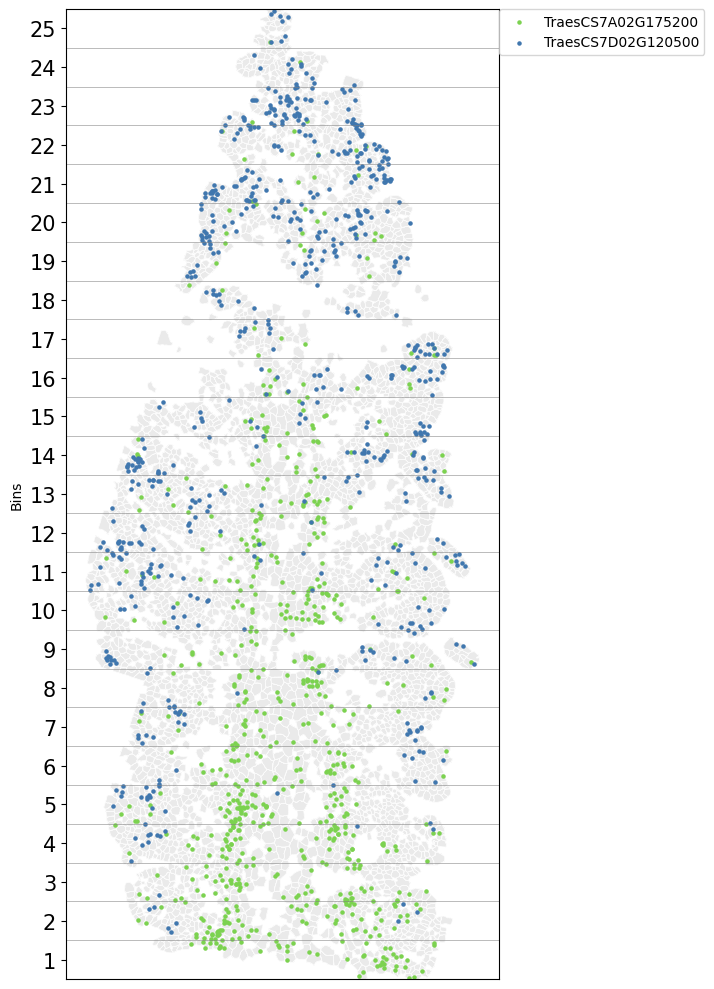

In [21]:
# Plot the segmentation and transcripts
fig, ax1 = plt.subplots(figsize=(20, 10))  # Single plot for segmentation and transcripts

collection = PatchCollection(rotated_patches_list, match_original=True)
ax1.add_collection(collection)

for gene, data in rotated_transcript_data.items():
    ax1.scatter(data['x'], data['y'], color=data['color'], s=5, alpha=1, label=gene)

for y_bin in y_bins:
    ax1.axhline(y=y_bin, color='gray', linewidth=0.5, alpha=0.75, zorder=1)

ax1.set_ylim([y_min, y_max])
ax1.set_aspect('equal')

bin_centers = (y_bins[:-1] + y_bins[1:]) / 2
ax1.set_yticks(bin_centers)
ax1.set_xticks([])
ax1.set_yticklabels(y_bin_labels, size=15)
ax1.set_xticklabels([])

ax1.set_ylabel('Bins')
ax1.legend(loc="upper left", bbox_to_anchor=(1, 1), borderaxespad=0)

# Save and show the first plot
plt.tight_layout()
plt.savefig('VRT2analysis/VRTA2a_spatialmap_transcripts.png', facecolor='white', edgecolor='none', format='png', dpi=700)
plt.show()


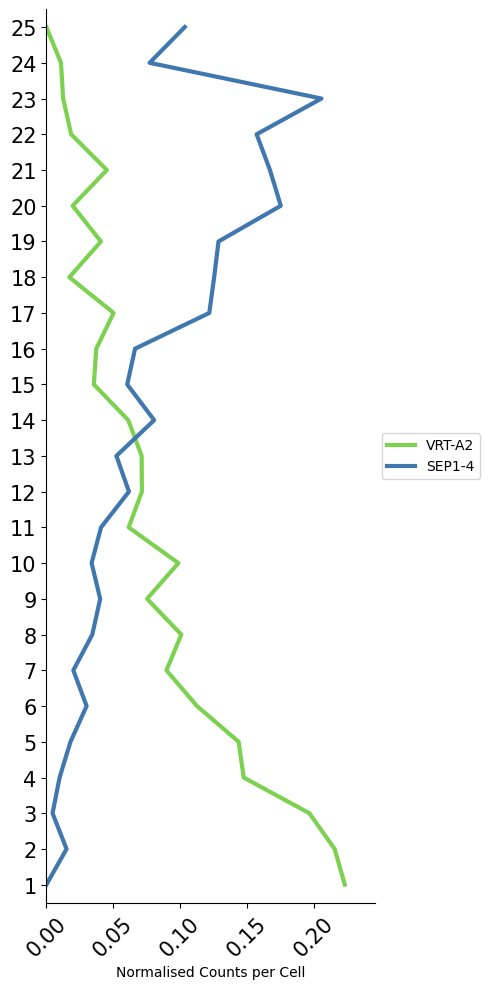

In [24]:
# Plot the line plot of counts
fig, ax2 = plt.subplots(figsize=(5, 10))  # Single plot for line plot of counts

gene = 'TraesCS7A02G175200'  # VRT-A2
gene2 = 'TraesCS7D02G120500'  # SEP1-4

ax2.plot(bindata[gene], bin_centers, label='VRT-A2', color='#7CD250', linewidth=3)
ax2.plot(bindata[gene2], bin_centers, label='SEP1-4', color='#4077AE', linewidth=3)

# Apply buffered Y-axis limits
buffer = 0.5  # Adjust the buffer size
ax2.set_ylim([y_min - buffer, y_max + buffer])
ax2.set_xlim([0, max(bindata[gene].max(), bindata[gene2].max()) * 1.1])  # Add a small buffer to the X-axis

ax2.set_xlabel('Normalised Counts per Cell', size=10)
ax2.set_yticks(bin_centers)
ax2.set_yticklabels(y_bin_labels, size=15)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.tick_params(axis='x', labelsize=15, labelrotation=45)

# Remove the black box on both plots
for spine in ['top', 'right']:
    ax2.spines[spine].set_visible(False)

# Save and show the second plot
plt.tight_layout()
plt.savefig('VRT2analysis/VRTA2a_transectplots.svg', facecolor='white', edgecolor='none', format='svg')
plt.show()


# Transect Plots Analysis of VRT-A2b (MUT, W4) inflorescence 
Select the spike of terminal spikelet WT sample, then bin along the y axis and summate counts

In [25]:
segmentation_df = gpd.read_parquet('cell_segmentation/VGN1a_region4_output/cellpose2_micron_space_VGN1a4.parquet')

transcripts_df = pd.read_csv('cell_segmentation/VGN1a_region4_output/detected_transcripts.csv') 

In [26]:
# I want to just look at cells in the inflorescence, which I selected in the VizGen MERSCOPE Visualiser tool 
file_path = 'VRT2analysis/24_10_24_allcellsinspike_VGN1a4.csv'
# Read the CSV file
cellgroups = pd.read_csv(file_path, header=0, index_col=0)

cell_list = cellgroups.index.tolist()

len(cell_list)

5875

In [27]:
# Filter cells to only those in the inflorescence 

#first make the cell id labels a string
segmentation_df['EntityID'] = segmentation_df['EntityID'].astype(str)

# Ensure cell_id_list also contains strings
cell_list = list(map(str, cell_list))

# Filter segmentation based on cell_id_list
filtered_segmentation_df = segmentation_df[segmentation_df['EntityID'].isin(cell_list)]
filtered_segmentation_df

ID             EntityID  ZIndex  \
281      281  2655350200007100010       3   
290      290  2655350200007100010       2   
299      299  2655350200007100010       4   
308      308  2655350200007100010       1   
317      317  2655350200007100010       5   
...      ...                  ...     ...   
10456  10456  2655350200055100164       1   
10393  10393  2655350200055100164       4   
10267  10267  2655350200055100164       3   
10645  10645  2655350200055100164       6   
10519  10519  2655350200055100164       5   

                                                Geometry ParentType ParentID  \
281    MULTIPOLYGON (((2957.086 6200.377, 2960.651 62...       None     None   
290    MULTIPOLYGON (((2957.086 6200.377, 2960.651 62...       None     None   
299    MULTIPOLYGON (((2957.086 6200.377, 2960.651 62...       None     None   
308    MULTIPOLYGON (((2957.086 6200.377, 2960.651 62...       None     None   
317    MULTIPOLYGON (((2957.086 6200.377, 2960.651 62...       None     None   
...                                                  ...        ...      ...   
10456  MULTIPOLYGON (((2682.259 8226.024, 2682.387 82...       None     None   
10393  MULTIPOLYGON (((2682.259 8226.024, 2682.387 82...       None     None   
10267  MULTIPOLYGON (((2682.259 8226.024, 2682.387 82...       None     None   
10645  MULTIPOLYGON (((2682.259 8226.024, 2682.387 82...       None     None   
10519  MULTIPOLYGON (((2682.259 8226.024, 2682.387 82...       None     None   

       Type  ZLevel  Name  
281    cell     6.0  None  
290    cell     4.5  None  
299    cell     7.5  None  
308    cell     3.0  None  
317    cell     9.0  None  
...     ...     ...   ...  
10456  cell     3.0  None  
10393  cell     7.5  None  
10267  cell     6.0  None  
10645  cell    10.5  None  
10519  cell     9.0  None  

[41125 rows x 9 columns]

In [28]:
#now I want to line up the transcripts and segmentation polygons, so I will do this by a spatial join
#I will filter so that only those transcripts that fall within cells are in the transcripts df

# Ensure segmentation_df is a GeoDataFrame
segmentation_df = gpd.GeoDataFrame(segmentation_df, geometry='Geometry')

# Convert transcripts_df to GeoDataFrame
transcripts_gdf = gpd.GeoDataFrame(
    transcripts_df,
    geometry=gpd.points_from_xy(transcripts_df['global_x'], transcripts_df['global_y'])
)

# Perform spatial join and drop duplicate rows
filtered_transcripts_gdf = gpd.sjoin(
    transcripts_gdf,
    filtered_segmentation_df[['EntityID', 'Geometry']],
    how='inner',
    predicate='within'
)

# Remove unnecessary columns and duplicates
filtered_transcripts_df = (
    filtered_transcripts_gdf
    .drop(columns=['index_right', 'Unnamed: 0'], errors='ignore')  # Drop join-related columns
    .drop_duplicates()  # Remove duplicate rows
)

# Reset the index for clarity
filtered_transcripts_df.reset_index(drop=True, inplace=True)

# Display result
filtered_transcripts_df


barcode_id   global_x   global_y  global_z           x            y  \
0                0  2714.8718  8212.2760       0.0  1063.76050   218.393250   
1                0  2732.9636  8216.6380       0.0  1231.27720   258.781040   
2                0  2725.9553  8221.5300       0.0  1166.38730   304.081500   
3                1  2743.9497  8199.7320       0.0  1333.00000   102.250916   
4                1  2741.0337  8202.0110       0.0  1306.00000   123.344120   
...            ...        ...        ...       ...         ...          ...   
990162         293  2958.0369  6317.7524       6.0  1346.00000  1308.285600   
990163         293  2905.5671  6386.3390       6.0   860.16754  1943.346600   
990164         294  2953.9790  6196.7065       6.0  1308.42590   187.490570   
990165         295  2914.5130  6300.9814       6.0   943.00000  1153.000000   
990166         297  2967.1090  6283.0160       6.0  1430.00000   986.652300   

        fov                gene         transcript_id              cell_id  \
0       236  TraesCS7D02G261600  TraesCS7D02G261600_2  2655350200055100148   
1       236  TraesCS7D02G261600  TraesCS7D02G261600_2  2655350200049100326   
2       236  TraesCS7D02G261600  TraesCS7D02G261600_2  2655350200049100326   
3       236  TraesCS5A02G286800  TraesCS5A02G286800_1  2655350200055100126   
4       236  TraesCS5A02G286800  TraesCS5A02G286800_1  2655350200049100307   
...     ...                 ...                   ...                  ...   
990162  294  TraesCS7D02G159800  TraesCS7D02G159800_3  2655350200007100083   
990163  294  TraesCS7D02G159800  TraesCS7D02G159800_3  2655350200013100019   
990164  294  TraesCS2A02G168200  TraesCS2A02G168200_1  2655350200007100013   
990165  294  TraesCS7A02G261100  TraesCS7A02G261100_1  2655350200007100072   
990166  294  TraesCS2A02G505000  TraesCS2A02G505000_1  2655350200007100053   

                         geometry             EntityID  
0       POINT (2714.872 8212.276)  2655350200055100148  
1       POINT (2732.964 8216.638)  2655350200049100326  
2       POINT (2725.955 8221.530)  2655350200049100326  
3       POINT (2743.950 8199.732)  2655350200055100126  
4       POINT (2741.034 8202.011)  2655350200049100307  
...                           ...                  ...  
990162  POINT (2958.037 6317.752)  2655350200007100083  
990163  POINT (2905.567 6386.339)  2655350200013100019  
990164  POINT (2953.979 6196.707)  2655350200007100013  
990165  POINT (2914.513 6300.981)  2655350200007100072  
990166  POINT (2967.109 6283.016)  2655350200007100053  

[990167 rows x 12 columns]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


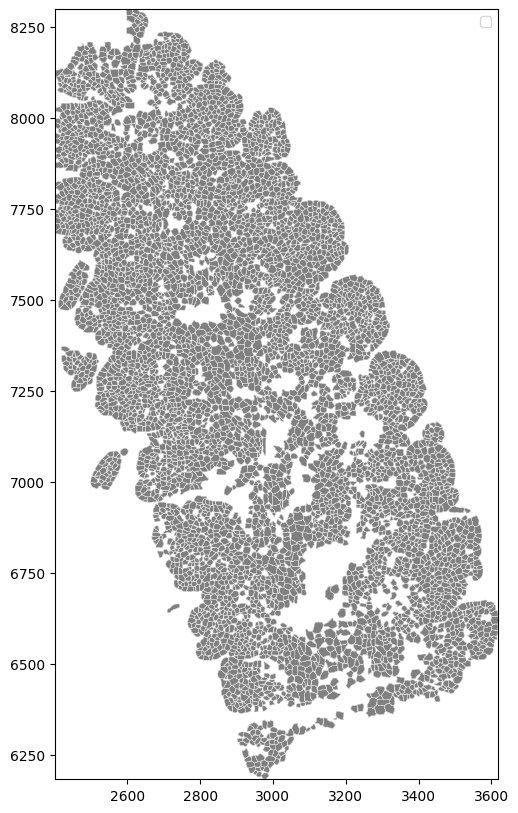

In [29]:
# Prepare a list of patches for plotting filtered segmentation cells
filtered_patches_list = []

# Add each filtered cell's polygon to the plot
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            patch = patches.Polygon(list(poly.exterior.coords), closed=True, facecolor="gray", edgecolor='white', linewidth=0.25)
            filtered_patches_list.append(patch)
    elif isinstance(shape, Polygon):
        patch = patches.Polygon(list(shape.exterior.coords), closed=True, facecolor="gray", edgecolor='white', linewidth=0.25)
        filtered_patches_list.append(patch)

# Calculate bounding box for the filtered segmentation cells
filtered_x_coords = [coord[0] for patch in filtered_patches_list for coord in patch.get_xy()]
filtered_y_coords = [coord[1] for patch in filtered_patches_list for coord in patch.get_xy()]
x_min, x_max = min(filtered_x_coords), max(filtered_x_coords)
y_min, y_max = min(filtered_y_coords), max(filtered_y_coords)

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 10))

# Add filtered segmentation polygons
collection = PatchCollection(filtered_patches_list, match_original=True)
ax.add_collection(collection)


# Set axis limits to focus on the area of interest
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_aspect('equal')

ax.legend()

plt.show()

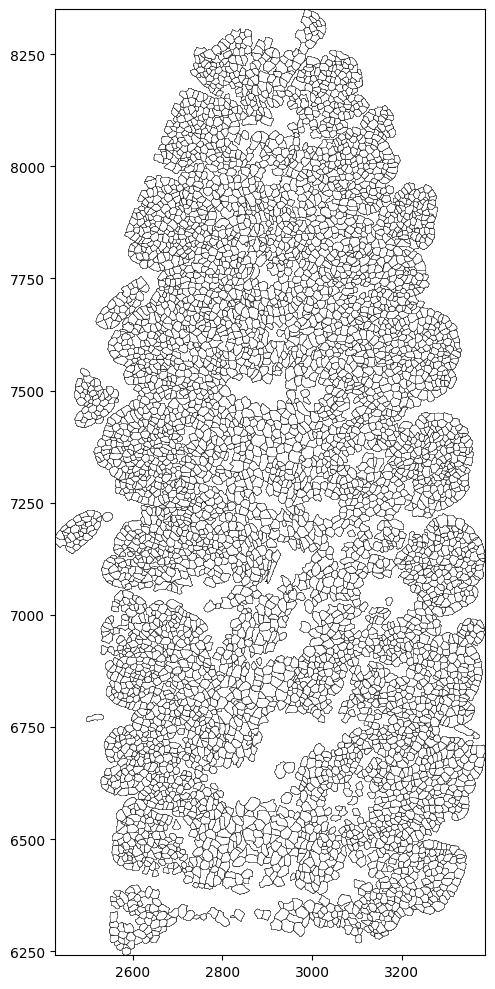

In [30]:
# Define rotation parameters
angle = 21  # Degrees
radians = math.radians(angle)
cos_angle = math.cos(radians)
sin_angle = math.sin(radians)
rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])

# Calculate the center of the filtered segmentation data for rotation
segmentation_center_x = filtered_segmentation_df['Geometry'].centroid.x.mean()
segmentation_center_y = filtered_segmentation_df['Geometry'].centroid.y.mean()

# Apply rotation to each Polygon in the filtered segmentation data
rotated_patches_list = []
rotated_polygons = []
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            centered_coords = np.array(poly.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
            rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
            rotated_poly = Polygon(rotated_coords)
            rotated_polygons.append(rotated_poly)
            patch = patches.Polygon(rotated_coords, closed=True, facecolor="white", edgecolor='black', linewidth=0.25)
            rotated_patches_list.append(patch)
    elif isinstance(shape, Polygon):
        centered_coords = np.array(shape.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
        rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
        rotated_poly = Polygon(rotated_coords)
        rotated_polygons.append(rotated_poly)
        patch = patches.Polygon(rotated_coords, closed=True, facecolor="white", edgecolor='black', linewidth=0.25)
        rotated_patches_list.append(patch)

# Plot the rotated polygons
fig, ax = plt.subplots(figsize=(10, 10))

# Add rotated polygons
collection = PatchCollection(rotated_patches_list, match_original=True)
ax.add_collection(collection)

# Calculate axis limits
rotated_x_coords = [coord[0] for patch in rotated_patches_list for coord in patch.get_xy()]
rotated_y_coords = [coord[1] for patch in rotated_patches_list for coord in patch.get_xy()]
x_min, x_max = min(rotated_x_coords), max(rotated_x_coords)
y_min, y_max = min(rotated_y_coords), max(rotated_y_coords)

# Set axis limits
ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_aspect('equal')

plt.tight_layout()
plt.show()


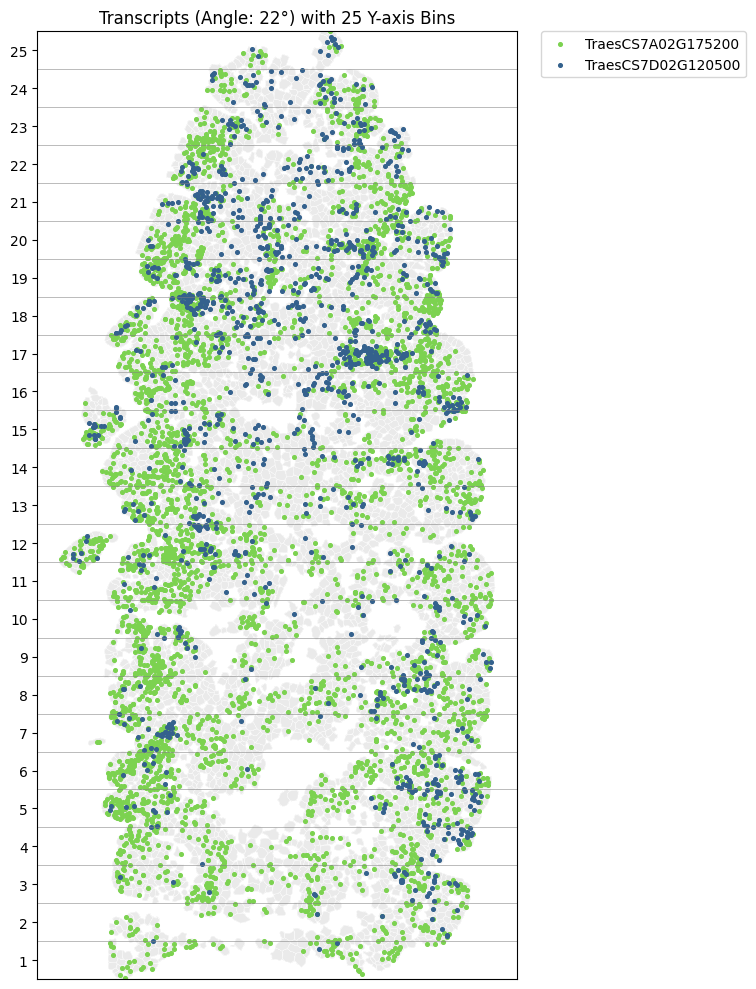

                 EntityID  Y_Bin
0     2655350200007100010    1.0
1     2655350200007100013    1.0
2     2655350200007100015    1.0
3     2655350200007100016    1.0
4     2655350200007100017    1.0
...                   ...    ...
5873  2655350200055100147   24.0
5874  2655350200055100148   24.0
5875  2655350200055100150   24.0
5876  2655350200055100158   24.0
5877  2655350200055100164   24.0

[5878 rows x 2 columns]


In [31]:
transcripts_in_area = filtered_transcripts_df.copy()

# Define genes and colors
genes_of_interest = {
    'TraesCS7A02G175200': '#7CD250',  # vRT2
    'TraesCS7D02G120500': '#34618D',  # SEP1-4
}

# Define rotation parameters
angle = 22 # Degrees
radians = math.radians(angle)
cos_angle = math.cos(radians)
sin_angle = math.sin(radians)
rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])

# Calculate the center of the filtered segmentation data for rotation
segmentation_center_x = filtered_segmentation_df['Geometry'].centroid.x.mean()
segmentation_center_y = filtered_segmentation_df['Geometry'].centroid.y.mean()

# Apply rotation to each Polygon in the filtered segmentation data
rotated_patches_list = []
rotated_polygons = []  # Store rotated polygons for containment checks
rotated_centroids = []  # Store centroids of rotated polygons for bin assignment
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            centered_coords = np.array(poly.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
            rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
            rotated_poly = Polygon(rotated_coords)
            rotated_polygons.append(rotated_poly)
            rotated_centroids.append(rotated_poly.centroid)
            patch = patches.Polygon(rotated_coords, closed=True, facecolor="#EAEAEA", edgecolor='white', linewidth=0.25)
            rotated_patches_list.append(patch)
    elif isinstance(shape, Polygon):
        centered_coords = np.array(shape.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
        rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
        rotated_poly = Polygon(rotated_coords)
        rotated_polygons.append(rotated_poly)
        rotated_centroids.append(rotated_poly.centroid)
        patch = patches.Polygon(rotated_coords, closed=True, facecolor="#EAEAEA", edgecolor='white', linewidth=0.25)
        rotated_patches_list.append(patch)

# Apply rotation to transcript coordinates
rotated_transcript_data = {}
for gene, color in genes_of_interest.items():
    transcripts_of_interest = transcripts_in_area[transcripts_in_area['gene'] == gene].copy()
    transcript_coords = transcripts_of_interest[['global_x', 'global_y']].to_numpy()
    centered_transcript_coords = transcript_coords - np.array([segmentation_center_x, segmentation_center_y])
    rotated_transcript_coords = np.dot(centered_transcript_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
    
    # Add rotated transcript coordinates for plotting
    rotated_transcript_data[gene] = {
        'x': rotated_transcript_coords[:, 0],
        'y': rotated_transcript_coords[:, 1],
        'color': color
    }

# Define bins along the Y-axis
rotated_y_coords = [centroid.y for centroid in rotated_centroids]
y_min, y_max = min(rotated_y_coords), max(rotated_y_coords)
num_bins = 25
y_bins = np.linspace(y_min, y_max, num_bins + 1)
y_bin_labels = list(range(1, num_bins + 1))  # Use simple numeric labels

# Assign Y-bin labels to each cell based on its rotated centroid's Y-coordinate
def assign_y_bin_to_cell(y_coord):
    """Assign Y-bin label based on the Y coordinate."""
    for i in range(len(y_bins) - 1):
        if y_bins[i] <= y_coord < y_bins[i + 1]:
            return y_bin_labels[i]  # Return numeric bin label
    return None

# Create a DataFrame with EntityID and Y-bin assignment
rotated_entity_bins = [
    {'EntityID': row.EntityID, 'Y_Bin': assign_y_bin_to_cell(centroid.y)}
    for row, centroid in zip(filtered_segmentation_df.itertuples(), rotated_centroids)
]

rotated_entity_bins_df = pd.DataFrame(rotated_entity_bins)

# Remove duplicates and reset index
rotated_entity_bins_df = rotated_entity_bins_df.drop_duplicates().reset_index(drop=True)

# Plot the rotated segmentation and transcripts
fig, ax = plt.subplots(figsize=(10, 10))

# Add rotated segmentation polygons
collection = PatchCollection(rotated_patches_list, match_original=True)
ax.add_collection(collection)

# Plot each gene's filtered transcripts with unique colors
for gene, data in rotated_transcript_data.items():
    ax.scatter(data['x'], data['y'], color=data['color'], s=7, alpha=1, label=gene)

# Draw Y-bin grid lines on the plot
for y_bin in y_bins:
    ax.axhline(y=y_bin, color='gray', linewidth=0.5, alpha=0.75, zorder=1)

# Set axis limits
ax.set_ylim([y_min, y_max])
ax.set_aspect('equal')

# Add custom Y-axis tick labels
bin_centers = (y_bins[:-1] + y_bins[1:]) / 2  # Calculate bin centers
plt.yticks(bin_centers, y_bin_labels)  # Replace y-axis ticks with numeric bin labels
plt.xticks([])
# Add title
ax.set_title(f"Transcripts (Angle: {angle}°) with 25 Y-axis Bins")

# Place the legend outside the plot
ax.legend(loc="upper left", bbox_to_anchor=(1.05, 1), borderaxespad=0)

plt.tight_layout()
plt.show()

# Display the cleaned DataFrame
print(rotated_entity_bins_df)



In [32]:
if isinstance(adata_VGN1a4.X, scipy.sparse.spmatrix):
    X_dense = adata_VGN1a4.X.toarray()
else:
    X_dense = adata_VGN1a4.X

    # Create gene expression matrix dataframe
cell_names = adata_VGN1a4.obs_names
gene_names = adata_VGN1a4.var_names
gene_expression_matrix = pd.DataFrame(data=X_dense, index=cell_names, columns=gene_names)

# Combine gene_expression_matrix with rotated_entity_bins_df by 'EntityID'
gene_expression_matrix.index.name = 'EntityID'

# Reset the index if necessary to make 'EntityID' a column
gene_expression_matrix = gene_expression_matrix.reset_index()

gene_expression_combineddf = pd.merge(
    gene_expression_matrix,
    rotated_entity_bins_df,
    on='EntityID',
    how='inner')

gene_expression_combineddf_VGN1a4 = gene_expression_combineddf.set_index('EntityID')
                                    
gene_expression_combineddf_VGN1a4


TraesCS7D02G261600  TraesCS5A02G286800  \
EntityID                                                      
2655350200007100010            0.000000            0.000000   
2655350200007100013            0.000000            0.000000   
2655350200007100015            0.000000            0.000000   
2655350200007100016            0.000000            0.000000   
2655350200007100017            0.000000            0.000000   
...                                 ...                 ...   
2655350200055100147            1.092181            2.556034   
2655350200055100148            0.533846            1.654961   
2655350200055100150            0.261917            1.647092   
2655350200055100158            0.988993            0.988993   
2655350200055100164            1.265033            1.806060   

                     TraesCS3A02G406500  TraesCS4D02G301100  \
EntityID                                                      
2655350200007100010            0.000000                 0.0   
2655350200007100013            0.000000                 0.0   
2655350200007100015            0.000000                 0.0   
2655350200007100016            1.032122                 0.0   
2655350200007100017            0.000000                 0.0   
...                                 ...                 ...   
2655350200055100147            0.000000                 0.0   
2655350200055100148            0.000000                 0.0   
2655350200055100150            0.000000                 0.0   
2655350200055100158            0.000000                 0.0   
2655350200055100164            0.000000                 0.0   

                     TraesCS1A02G264300  TraesCS4D02G243700  \
EntityID                                                      
2655350200007100010            0.000000                 0.0   
2655350200007100013            0.000000                 0.0   
2655350200007100015            0.000000                 0.0   
2655350200007100016            0.000000                 0.0   
2655350200007100017            0.000000                 0.0   
...                                 ...                 ...   
2655350200055100147            0.000000                 0.0   
2655350200055100148            0.000000                 0.0   
2655350200055100150            0.261917                 0.0   
2655350200055100158            0.000000                 0.0   
2655350200055100164            0.000000                 0.0   

                     TraesCS1D02G127700  TraesCS7D02G388600  \
EntityID                                                      
2655350200007100010            0.000000            0.000000   
2655350200007100013            0.000000            0.000000   
2655350200007100015            0.000000            0.000000   
2655350200007100016            0.000000            1.032122   
2655350200007100017            0.000000            0.000000   
...                                 ...                 ...   
2655350200055100147            1.092181            0.000000   
2655350200055100148            0.000000            0.000000   
2655350200055100150            0.000000            0.000000   
2655350200055100158            0.000000            0.000000   
2655350200055100164            0.000000            0.000000   

                     TraesCS6A02G259000  TraesCS3B02G608600  ...  \
EntityID                                                     ...   
2655350200007100010            0.000000            0.000000  ...   
2655350200007100013            0.000000            0.000000  ...   
2655350200007100015            0.000000            0.000000  ...   
2655350200007100016            0.000000            0.000000  ...   
2655350200007100017            0.000000            0.000000  ...   
...                                 ...                 ...  ...   
2655350200055100147            2.556034            0.000000  ...   
2655350200055100148            2.715330            0.533846  ...   
2655350200055100150            1.756253            0.000000  

In [33]:
# Extract cell identifiers and cluster assignments
cell_cluster_assignments = adata_spatial.obs[['clusters']]

# Optionally reset the index to get the cell IDs as a column
cell_cluster_assignments.reset_index(inplace=True)

# Rename columns for clarity
cell_cluster_assignments.columns = ['cell_id', 'cluster']

# Save to a DataFrame
df_cell_cluster_assignments = pd.DataFrame(cell_cluster_assignments)

# Ensure that 'cell_id' is treated as a string column
df_cell_cluster_assignments['cell_id'] = df_cell_cluster_assignments['cell_id'].astype(str)

# Split the 'cell_id' column by '-' and expand into two columns
split_columns = df_cell_cluster_assignments['cell_id'].str.split('-', expand=True)

# Assign the first part to 'cell_id' and the second part to 'sample'
df_cell_cluster_assignments['cell_id'] = split_columns[0]
df_cell_cluster_assignments['sample'] = split_columns[1]

#this makes a dataframe with cell id, cluster assignment, and sample id
df_cell_cluster_assignments.set_index('cell_id', inplace=True)


final_gene_expression_combineddf = pd.merge(
    df_cell_cluster_assignments,
    gene_expression_combineddf_VGN1a4,
    left_index=True,
    right_index=True,
    how='inner'  # Use inner join to keep only matching rows
)
VGN1a4_df = final_gene_expression_combineddf.copy()

final_gene_expression_combineddf

cluster  sample  TraesCS7D02G261600  TraesCS5A02G286800  \
cell_id                                                                       
2655350200007100010      12  VGN1a4            0.000000            0.000000   
2655350200007100013      12  VGN1a4            0.000000            0.000000   
2655350200007100015      12  VGN1a4            0.000000            0.000000   
2655350200007100016      12  VGN1a4            0.000000            0.000000   
2655350200007100017      12  VGN1a4            0.000000            0.000000   
...                     ...     ...                 ...                 ...   
2655350200055100147      16  VGN1a4            1.092181            2.556034   
2655350200055100148      15  VGN1a4            0.533846            1.654961   
2655350200055100150      15  VGN1a4            0.261917            1.647092   
2655350200055100158      15  VGN1a4            0.988993            0.988993   
2655350200055100164      16  VGN1a4            1.265033            1.806060   

                     TraesCS3A02G406500  TraesCS4D02G301100  \
cell_id                                                       
2655350200007100010            0.000000                 0.0   
2655350200007100013            0.000000                 0.0   
2655350200007100015            0.000000                 0.0   
2655350200007100016            1.032122                 0.0   
2655350200007100017            0.000000                 0.0   
...                                 ...                 ...   
2655350200055100147            0.000000                 0.0   
2655350200055100148            0.000000                 0.0   
2655350200055100150            0.000000                 0.0   
2655350200055100158            0.000000                 0.0   
2655350200055100164            0.000000                 0.0   

                     TraesCS1A02G264300  TraesCS4D02G243700  \
cell_id                                                       
2655350200007100010            0.000000                 0.0   
2655350200007100013            0.000000                 0.0   
2655350200007100015            0.000000                 0.0   
2655350200007100016            0.000000                 0.0   
2655350200007100017            0.000000                 0.0   
...                                 ...                 ...   
2655350200055100147            0.000000                 0.0   
2655350200055100148            0.000000                 0.0   
2655350200055100150            0.261917                 0.0   
2655350200055100158            0.000000                 0.0   
2655350200055100164            0.000000                 0.0   

                     TraesCS1D02G127700  TraesCS7D02G388600  ...  \
cell_id                                                      ...   
2655350200007100010            0.000000            0.000000  ...   
2655350200007100013            0.000000            0.000000  ...   
2655350200007100015            0.000000            0.000000  ...   
2655350200007100016            0.000000            1.032122  ...   
2655350200007100017            0.000000            0.000000  ...   
...                                 ...                 ...  ...   
2655350200055100147            1.092181            0.000000  ...   
2655350200055100148            0.000000            0.000000  ...   
2655350200055100150            0.000000            0.000000  ...   
2655350200055100158            0.000000            0.000000  ...   
2655350200055100164            0.000000            0.000000  ...   

                     TraesCS5A02G405900  TraesCS5B02G560300  \
cell_id                                                       
2655350200007100010                 0.0            0.000000   
2655350200007100013                 0.0            0.000000   
2655350200007100015                 0.0            0.000000   
2655350200007100016                 0.0            0.000000   
2655350200007100017                 0.0            0.000000   
...                       

In [34]:
data = final_gene_expression_combineddf.copy()
data = data.drop(['cluster', 'sample'], axis=1)
data = data.groupby('Y_Bin').mean().reset_index()
data = data.drop(['Y_Bin'], axis=1)
data = data.transpose()

# Step 1: Transpose the DataFrame
df_transposed = data.T

# Step 2: Fill NaN values
df_filled = df_transposed.fillna(0)

bindata = df_filled.copy()
bindata['y_bin'] = bindata.index + 1
bindata = bindata[['TraesCS7A02G175200', 'TraesCS7D02G120500', 'y_bin']]
bindata

TraesCS7A02G175200  TraesCS7D02G120500  y_bin
0             0.520974            0.027817      1
1             0.331815            0.031675      2
2             0.351671            0.039188      3
3             0.328850            0.037119      4
4             0.425728            0.061392      5
5             0.411786            0.070492      6
6             0.379927            0.059460      7
7             0.389626            0.050804      8
8             0.351919            0.049915      9
9             0.347868            0.078063     10
10            0.351293            0.049188     11
11            0.421612            0.081061     12
12            0.350647            0.084119     13
13            0.308201            0.063961     14
14            0.281569            0.129158     15
15            0.306310            0.123083     16
16            0.335188            0.095411     17
17            0.395771            0.181066     18
18            0.275350            0.165163     19
19            0.257190            0.148295     20
20            0.294123            0.196975     21
21            0.277606            0.143651     22
22            0.286677            0.159003     23
23            0.214065            0.183732     24
24            0.409930            0.107030     25

In [63]:
# Define genes and colors
genes_of_interest = {
    'TraesCS7A02G175200': '#7CD250',  # VRT2
    'TraesCS7D02G120500': '#3083DC',  # SEP1-4
}

# Define rotation parameters
angle = 22  # Degrees
radians = math.radians(angle)
cos_angle = math.cos(radians)
sin_angle = math.sin(radians)
rotation_matrix = np.array([[cos_angle, -sin_angle], [sin_angle, cos_angle]])

# Calculate the center of the filtered segmentation data for rotation
segmentation_center_x = filtered_segmentation_df['Geometry'].centroid.x.mean()
segmentation_center_y = filtered_segmentation_df['Geometry'].centroid.y.mean()

# Apply rotation to each Polygon in the filtered segmentation data
rotated_patches_list = []
rotated_polygons = []  # Store rotated polygons for containment checks
rotated_centroids = []  # Store centroids of rotated polygons for bin assignment
for _, row in filtered_segmentation_df.iterrows():
    shape = row['Geometry']
    if isinstance(shape, MultiPolygon):
        for poly in shape.geoms:
            centered_coords = np.array(poly.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
            rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
            rotated_poly = Polygon(rotated_coords)
            rotated_polygons.append(rotated_poly)
            rotated_centroids.append(rotated_poly.centroid)
            patch = patches.Polygon(rotated_coords, closed=True, facecolor="#EAEAEA", edgecolor='white', linewidth=0.45)
            rotated_patches_list.append(patch)
    elif isinstance(shape, Polygon):
        centered_coords = np.array(shape.exterior.coords) - np.array([segmentation_center_x, segmentation_center_y])
        rotated_coords = np.dot(centered_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
        rotated_poly = Polygon(rotated_coords)
        rotated_polygons.append(rotated_poly)
        rotated_centroids.append(rotated_poly.centroid)
        patch = patches.Polygon(rotated_coords, closed=True, facecolor="#EAEAEA", edgecolor='white', linewidth=0.45)
        rotated_patches_list.append(patch)

# Apply rotation to transcript coordinates
rotated_transcript_data = {}
for gene, color in genes_of_interest.items():
    transcripts_of_interest = transcripts_in_area[transcripts_in_area['gene'] == gene].copy()
    transcript_coords = transcripts_of_interest[['global_x', 'global_y']].to_numpy()
    centered_transcript_coords = transcript_coords - np.array([segmentation_center_x, segmentation_center_y])
    rotated_transcript_coords = np.dot(centered_transcript_coords, rotation_matrix) + np.array([segmentation_center_x, segmentation_center_y])
    
    # Add rotated transcript coordinates for plotting
    rotated_transcript_data[gene] = {
        'x': rotated_transcript_coords[:, 0],
        'y': rotated_transcript_coords[:, 1],
        'color': color
    }

# Define bins along the Y-axis
rotated_y_coords = [centroid.y for centroid in rotated_centroids]
y_min, y_max = min(rotated_y_coords), max(rotated_y_coords)
num_bins = 25
y_bins = np.linspace(y_min, y_max, num_bins + 1)
y_bin_labels = list(range(1, num_bins + 1))  # Use simple numeric labels

# Assign Y-bin labels to each cell based on its rotated centroid's Y-coordinate
def assign_y_bin_to_cell(y_coord):
    """Assign Y-bin label based on the Y coordinate."""
    for i in range(len(y_bins) - 1):
        if y_bins[i] <= y_coord < y_bins[i + 1]:
            return y_bin_labels[i]  # Return numeric bin label
    return None

# Create a DataFrame with EntityID and Y-bin assignment
rotated_entity_bins = [
    {'EntityID': row.EntityID, 'Y_Bin': assign_y_bin_to_cell(centroid.y)}
    for row, centroid in zip(filtered_segmentation_df.itertuples(), rotated_centroids)
]

rotated_entity_bins_df = pd.DataFrame(rotated_entity_bins)

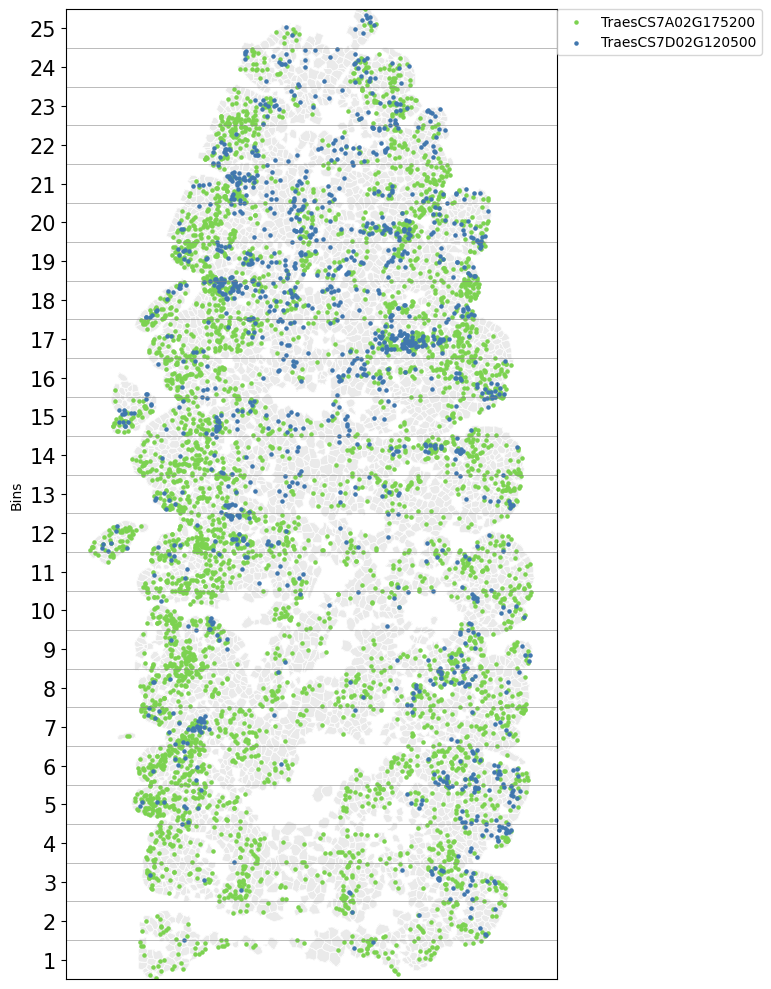

In [37]:
# Plot the segmentation and transcripts
fig, ax1 = plt.subplots(figsize=(20, 10))  # Single plot for segmentation and transcripts

collection = PatchCollection(rotated_patches_list, match_original=True)
ax1.add_collection(collection)

for gene, data in rotated_transcript_data.items():
    ax1.scatter(data['x'], data['y'], color=data['color'], s=5, alpha=1, label=gene)

for y_bin in y_bins:
    ax1.axhline(y=y_bin, color='gray', linewidth=0.5, alpha=0.75, zorder=1)

ax1.set_ylim([y_min, y_max])
ax1.set_aspect('equal')

bin_centers = (y_bins[:-1] + y_bins[1:]) / 2
ax1.set_yticks(bin_centers)
ax1.set_xticks([])
ax1.set_yticklabels(y_bin_labels, size=15)
ax1.set_xticklabels([])

ax1.set_ylabel('Bins')
ax1.legend(loc="upper left", bbox_to_anchor=(1, 1), borderaxespad=0)

# Save and show the first plot
plt.tight_layout()
plt.savefig('VRT2analysis/VRTA2b_spatialmap_transcripts.png', facecolor='white', edgecolor='none', format='png', dpi=700)
plt.show()


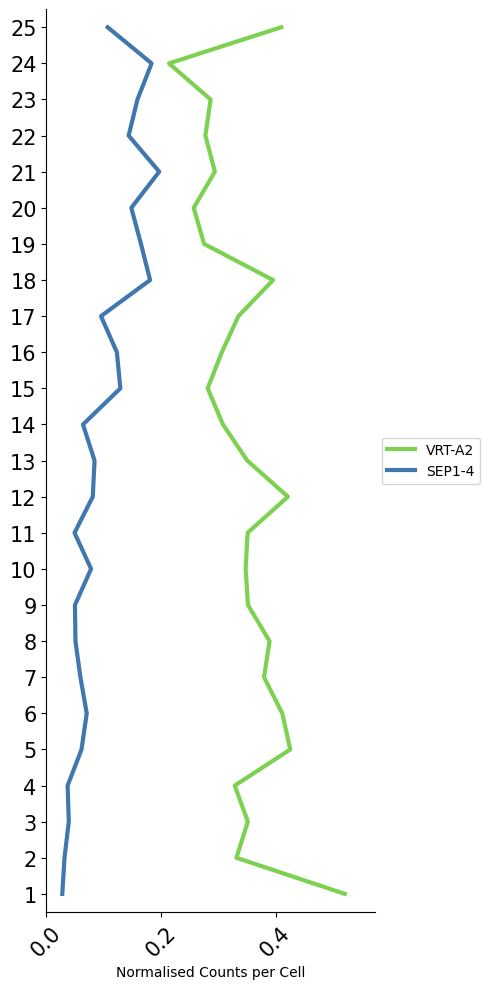

In [39]:
# Plot the line plot of counts
fig, ax2 = plt.subplots(figsize=(5, 10))  # Single plot for line plot of counts

gene = 'TraesCS7A02G175200'  # VRT-A2
gene2 = 'TraesCS7D02G120500'  # SEP1-4

ax2.plot(bindata[gene], bin_centers, label='VRT-A2', color='#7CD250', linewidth=3)
ax2.plot(bindata[gene2], bin_centers, label='SEP1-4', color='#4077AE', linewidth=3)

# Apply buffered Y-axis limits
buffer = 0.5  # Adjust the buffer size
ax2.set_ylim([y_min - buffer, y_max + buffer])
ax2.set_xlim([0, max(bindata[gene].max(), bindata[gene2].max()) * 1.1])  # Add a small buffer to the X-axis

ax2.set_xlabel('Normalised Counts per Cell', size=10)
ax2.set_yticks(bin_centers)
ax2.set_yticklabels(y_bin_labels, size=15)
ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax2.tick_params(axis='x', labelsize=15, labelrotation=45)

# Remove the black box on both plots
for spine in ['top', 'right']:
    ax2.spines[spine].set_visible(False)

# Save and show the second plot
plt.tight_layout()
plt.savefig('VRT2analysis/VRTA2b_transectplots.svg', facecolor='white', edgecolor='none', format='svg')
plt.show()


In [49]:
# I want to write in a csv the normalised expression values that went into VRT-A2a and VRT-A2b gradient/transect plots for later 
gene_expression_combineddf_VGN1a6['sample'] = 'VGN1a6'
gene_expression_combineddf_VGN1a4['sample'] = 'VGN1a4'


gene_expression_binmatrix_bothsamples = pd.concat([gene_expression_combineddf_VGN1a6, gene_expression_combineddf_VGN1a4], axis=0, ignore_index=True)
gene_expression_binmatrix_bothsamples.to_csv("VRT2analysis/Figure4CellAssignment_TransverseBins_NormExpCounts_VRTA2a_VRTA2b.csv", index=False)
gene_expression_binmatrix_bothsamples

TraesCS7D02G261600  TraesCS5A02G286800  TraesCS3A02G406500  \
0                0.000000            0.000000            0.103219   
1                0.000000            0.000000            0.000000   
2                0.000000            0.000000            0.422560   
3                0.000000            0.000000            0.000000   
4                0.000000            0.000000            0.000000   
...                   ...                 ...                 ...   
10576            1.092181            2.556034            0.000000   
10577            0.533846            1.654961            0.000000   
10578            0.261917            1.647092            0.000000   
10579            0.988993            0.988993            0.000000   
10580            1.265033            1.806060            0.000000   

       TraesCS4D02G301100  TraesCS1A02G264300  TraesCS4D02G243700  \
0                     0.0            0.000000                 0.0   
1                     0.0            0.000000                 0.0   
2                     0.0            0.000000                 0.0   
3                     0.0            0.000000                 0.0   
4                     0.0            0.000000                 0.0   
...                   ...                 ...                 ...   
10576                 0.0            0.000000                 0.0   
10577                 0.0            0.000000                 0.0   
10578                 0.0            0.261917                 0.0   
10579                 0.0            0.000000                 0.0   
10580                 0.0            0.000000                 0.0   

       TraesCS1D02G127700  TraesCS7D02G388600  TraesCS6A02G259000  \
0                0.000000                 0.0            0.103219   
1                0.000000                 0.0            0.000000   
2                0.000000                 0.0            0.000000   
3                0.000000                 0.0            0.000000   
4                0.000000                 0.0            0.000000   
...                   ...                 ...                 ...   
10576            1.092181                 0.0            2.556034   
10577            0.000000                 0.0            2.715330   
10578            0.000000                 0.0            1.756253   
10579            0.000000                 0.0            2.409747   
10580            0.000000                 0.0            2.292660   

       TraesCS3B02G608600  ...  TraesCS5B02G560300  TraesCS6A02G373500  \
0                0.103219  ...            0.000000            0.000000   
1                0.000000  ...            0.000000            0.000000   
2                0.000000  ...            0.000000            0.422560   
3                0.000000  ...            0.000000            0.223966   
4                0.000000  ...            0.000000            0.826020   
...                   ...  ...                 ...                 ...   
10576            0.000000  ...            0.000000            1.092181   
10577            0.533846  ...            0.533846            0.000000   
10578            0.000000  ...            0.000000            0.000000   
10579            0.000000  ...            0.000000            0.000000   
10580            0.000000  ...            0.000000            0.000000   

       TraesCS2B02G260800  TraesCS1B02G283900  TraesCS6A02G213700  \
0                1.370121            0.103219            0.282320   
1                1.372920            0.000000            0.258268   
2                1.649984            0.000000            0.000000   
3                1.389376            0.000000            0.406836   
4                0.495979            0.000000            0.000000   
...                   ...                 ...                 ...   
10576            1.092181            0.000000            0.000000   
10577            1.654961            0.000000            0.000000   
10578     

# now I will look at percentage of cells expressing genes of interest in the VRT-A2a & VRT-A2b lines 

In [50]:
# I want to just look at cells in the inflorescence, which I selected in the VizGen MERSCOPE Visualiser tool 
cellsinspike = pd.read_csv('VRT2analysis/24_10_24_allcellsinspike_VGN1a6.csv')
cellsinspike.rename(columns={cellsinspike.columns[0]: 'cell_id'}, inplace=True)
cellsinspike['cell_id'] = cellsinspike['cell_id'].astype(str)

cell_id_list = cellsinspike['cell_id'].tolist()

cellsinspike

cell_id
0     2305551000007100071
1     2305551000007100077
2     2305551000007100085
3     2305551000007100086
4     2305551000007100092
...                   ...
4691  2305551000055100192
4692  2305551000055100193
4693  2305551000055100206
4694  2305551000055100217
4695  2305551000055100230

[4696 rows x 1 columns]

In [51]:
#Extract the  expression values for cells only in inflorescence, convert them to '0' or '1' to represent expressed/not expressed
filtered_combined_df = VGN1a6_df[VGN1a6_df.index.isin(cell_id_list)]

norm_data_VGN1a6 = filtered_combined_df.copy()

# Step 1: Binarize the expression values (1 if expressed, 0 if not)
binary_expression_df = norm_data_VGN1a6.drop(['cluster', 'sample', 'Y_Bin'], axis=1).applymap(lambda x: 1 if x > 0 else 0)
binary_expression_df['cluster'] = norm_data_VGN1a6['cluster']
binary_expression_df['sample'] = norm_data_VGN1a6['sample']
binary_expression_df

TraesCS7D02G261600  TraesCS5A02G286800  \
cell_id                                                       
2305551000007100071                   0                   0   
2305551000007100077                   0                   0   
2305551000007100085                   0                   0   
2305551000007100086                   0                   0   
2305551000007100092                   0                   0   
...                                 ...                 ...   
2305551000055100193                   1                   0   
2305551000055100206                   0                   0   
2305551000055100217                   0                   0   
2305551000055100230                   0                   0   
2305551000055100230                   0                   0   

                     TraesCS3A02G406500  TraesCS4D02G301100  \
cell_id                                                       
2305551000007100071                   1                   0   
2305551000007100077                   0                   0   
2305551000007100085                   1                   0   
2305551000007100086                   0                   0   
2305551000007100092                   0                   0   
...                                 ...                 ...   
2305551000055100193                   0                   0   
2305551000055100206                   1                   0   
2305551000055100217                   0                   0   
2305551000055100230                   0                   0   
2305551000055100230                   0                   0   

                     TraesCS1A02G264300  TraesCS4D02G243700  \
cell_id                                                       
2305551000007100071                   0                   0   
2305551000007100077                   0                   0   
2305551000007100085                   0                   0   
2305551000007100086                   0                   0   
2305551000007100092                   0                   0   
...                                 ...                 ...   
2305551000055100193                   0                   0   
2305551000055100206                   0                   1   
2305551000055100217                   0                   0   
2305551000055100230                   0                   0   
2305551000055100230                   0                   0   

                     TraesCS1D02G127700  TraesCS7D02G388600  \
cell_id                                                       
2305551000007100071                   0                   0   
2305551000007100077                   0                   0   
2305551000007100085                   0                   0   
2305551000007100086                   0                   0   
2305551000007100092                   0                   0   
...                                 ...                 ...   
2305551000055100193                   0                   0   
2305551000055100206                   0                   0   
2305551000055100217                   0                   0   
2305551000055100230                   0                   0   
2305551000055100230                   0                   0   

                     TraesCS6A02G259000  TraesCS3B02G608600  ...  \
cell_id                                                      ...   
2305551000007100071                   1                   1  ...   
2305551000007100077                   0                   0  ...   
2305551000007100085                   0                   0  ...   
2305551000007100086                   0                   0  ...   
2305551000007100092                   0                   0  ...   
...                                 ...                 ...  ...   
2305551000055100193                   0                   0  ...   
2305551000055100206                   0                   0  ...   
2305551000055100217                   0                   0  

In [53]:
# Select the relevant columns
selected_df = binary_expression_df[['TraesCS7A02G175200', 'TraesCS7D02G120500', 'cluster', 'sample']]

# List to store the results for each cluster
cluster_grouped_results = []

# Group by 'cluster' and perform the analysis for each group
for cluster, group in selected_df.groupby('cluster'):
    # Calculate the total number of cells in the cluster
    total_cells_count = group.shape[0]
    
    # Calculate the number of cells co-expressing both genes
    coexpressing_cells_count = group[(group['TraesCS7A02G175200'] == 1) & (group['TraesCS7D02G120500'] == 1)].shape[0]
    
    # Calculate the number of cells expressing only TraesCS7A02G175200 (VRT2)
    vrt2_only_cells_count = group[(group['TraesCS7A02G175200'] == 1) & (group['TraesCS7D02G120500'] == 0)].shape[0]
    
    # Calculate the number of cells expressing only TraesCS7D02G120500 (SEP1-4)
    sep1_4_only_cells_count = group[(group['TraesCS7A02G175200'] == 0) & (group['TraesCS7D02G120500'] == 1)].shape[0]
    
    # Calculate the number of cells expressing neither gene
    neither_cells_count = group[(group['TraesCS7A02G175200'] == 0) & (group['TraesCS7D02G120500'] == 0)].shape[0]
    
    # Calculate the percentages
    percentage_coexpressing = (coexpressing_cells_count / total_cells_count) * 100 if total_cells_count > 0 else 0
    percentage_vrt2 = (vrt2_only_cells_count / total_cells_count) * 100 if total_cells_count > 0 else 0
    percentage_sep1_4 = (sep1_4_only_cells_count / total_cells_count) * 100 if total_cells_count > 0 else 0
    percentage_neither = (neither_cells_count / total_cells_count) * 100 if total_cells_count > 0 else 0
    
    # Append the results to the list
    cluster_grouped_results.append({
        'cluster': cluster,
        'total_cells_count': total_cells_count,
        'co-expressed': coexpressing_cells_count,
        'VRT2': vrt2_only_cells_count,
        'SEP1-4': sep1_4_only_cells_count,
        'neither': neither_cells_count,
        'percentage_coexpressing': percentage_coexpressing,
        'percentage_vrt2': percentage_vrt2,
        'percentage_sep1_4': percentage_sep1_4,
        'percentage_neither': percentage_neither
    })

# Convert the list of results into a DataFrame
cluster_results_df = pd.DataFrame(cluster_grouped_results)

# Set 'cluster' as the index
cluster_results_df.set_index('cluster', inplace=True)

# Add sample information
cluster_results_df['sample'] = 'VGN1a6'

# Optional: Store the DataFrame for further analysis
coexpression_df_VGN1a6 = cluster_results_df.copy()

# Display the DataFrame
cluster_results_df


total_cells_count  co-expressed  VRT2  SEP1-4  neither  \
cluster                                                           
0                     1171            10   134      81      946   
1                      336             6    19      80      231   
2                      270             3     6      81      180   
3                      635             5   199       4      427   
4                      632             0    26      77      529   
5                      248             1    30      10      207   
6                      247             5    29      50      163   
7                      233             0    11      14      208   
8                      157             3     3      35      116   
9                       18             0     8       0       10   
10                      40             0     3       3       34   
11                     282             0    19      20      243   
12                     137             0    16       1      120   
13                      49             0     2      15       32   
14                      35             0     1       1       33   
15                     134             1     4      15      114   
16                      78             0     3       1       74   
17                       1             0     0       0        1   

         percentage_coexpressing  percentage_vrt2  percentage_sep1_4  \
cluster                                                                
0                       0.853971        11.443211           6.917165   
1                       1.785714         5.654762          23.809524   
2                       1.111111         2.222222          30.000000   
3                       0.787402        31.338583           0.629921   
4                       0.000000         4.113924          12.183544   
5                       0.403226        12.096774           4.032258   
6                       2.024291        11.740891          20.242915   
7                       0.000000         4.721030           6.008584   
8                       1.910828         1.910828          22.292994   
9                       0.000000        44.444444           0.000000   
10                      0.000000         7.500000           7.500000   
11                      0.000000         6.737589           7.092199   
12                      0.000000        11.678832           0.729927   
13                      0.000000         4.081633          30.612245   
14                      0.000000         2.857143           2.857143   
15                      0.746269         2.985075          11.194030   
16                      0.000000         3.846154           1.282051   
17                      0.000000         0.000000           0.000000   

         percentage_neither  sample  
cluster                              
0                 80.785653  VGN1a6  
1                 68.750000  VGN1a6  
2                 66.666667  VGN1a6  
3                 67.244094  VGN1a6  
4                 83.702532  VGN1a6  
5                 83.467742  VGN1a6  
6                 65.991903  VGN1a6  
7                 89.270386  VGN1a6  
8                 73.885350  VGN1a6  
9                 55.555556  VGN1a6  
10                85.000000  VGN1a6  
11                86.170213  VGN1a6  
12                87.591241  VGN1a6  
13                65.306122  VGN1a6  
14                94.285714  VGN1a6  
15                85.074627  VGN1a6  
16                94.871795  VGN1a6  
17               100.000000  VGN1a6

In [60]:
## calculate number of cells and percentage of cells co-expressing both genes across the sample 

selected_df2 = selected_df.drop(['sample'], axis=1)

coexpressing_cells_count = selected_df2[(selected_df2['TraesCS7A02G175200'] == 1) & (selected_df2['TraesCS7D02G120500'] == 1)].shape[0]

# Calculate the number of rows where both 'TraesCS7A02G175200' and 'TraesCS7D02G120500' are 1
coexpressing_cells_count = selected_df2[(selected_df2['TraesCS7A02G175200'] == 1) & (selected_df2['TraesCS7D02G120500'] == 1)].shape[0]

# Calculate the percentage of cells co-expressing the genes
total_cells_count = selected_df2.shape[0]
percentage_coexpressing = (coexpressing_cells_count / total_cells_count) * 100

# Print the results
print("Number of cells co-expressing both genes:", coexpressing_cells_count)
print("Percentage of cells co-expressing both genes:", percentage_coexpressing)


Number of cells co-expressing both genes: 484
Percentage of cells co-expressing both genes: 8.234093228989451


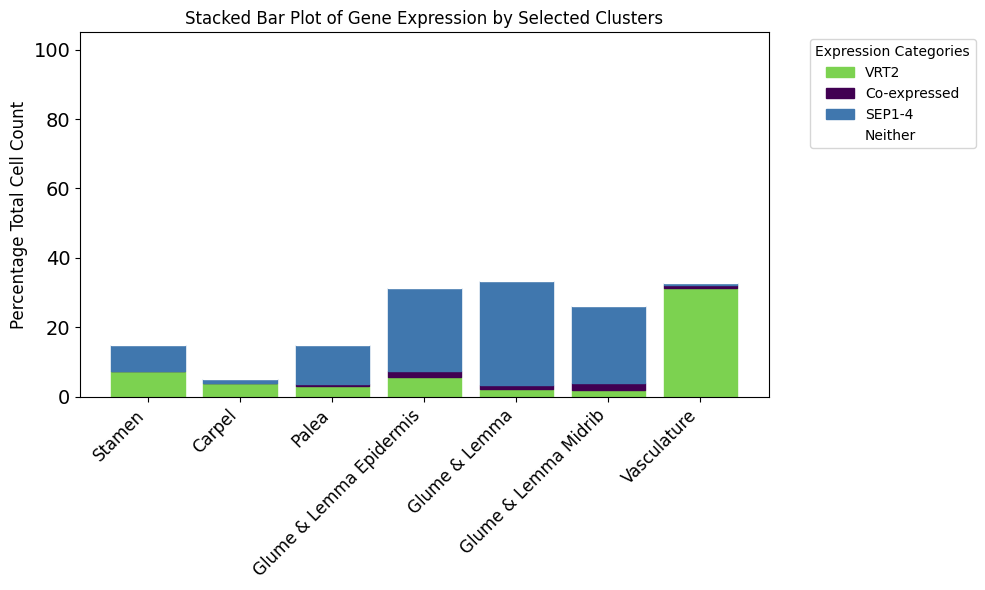

In [93]:
# Map of clusters to their descriptions
cluster_labels = {
    '3': 'Vasculature',
    '1': 'Glume & Lemma Epidermis',
    '2': 'Glume & Lemma',
    '8': 'Glume & Lemma Midrib',
    '15': 'Palea',
    '10': 'Stamen',
    '14': 'Stamen epidermis',
    '16': 'Carpel'
}

# Select and reorder the clusters
clusters_to_plot = ['10', '16', '15', '1', '2', '8', '3']
filtered_df = coexpression_df_VGN1a6.loc[clusters_to_plot]

# Data for the stacked bar plot
x = filtered_df.index  # Cluster numbers
vrt2 = filtered_df['percentage_vrt2']
co_expressed = filtered_df['percentage_coexpressing']
sep1_4 = filtered_df['percentage_sep1_4']
neither = filtered_df['percentage_neither']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x, vrt2, label='VRT2', edgecolor='#7CD250', color='#7CD250')
plt.bar(x, co_expressed, bottom=vrt2, label='Co-expressed', edgecolor='#410052', color='#410052')
plt.bar(x, sep1_4, bottom=vrt2 + co_expressed, label='SEP1-4', edgecolor= '#4077AE', color='#4077AE')
plt.bar(x, neither, bottom=vrt2 + co_expressed + sep1_4, label='Neither', edgecolor='white', color='white')

plt.ylabel('Percentage Total Cell Count', size = 12)
plt.title('Stacked Bar Plot of Gene Expression by Selected Clusters')
plt.legend(title='Expression Categories', bbox_to_anchor=(1.05, 1), loc='upper left')

# Replace x-axis labels with cluster descriptions
xtick_labels = [cluster_labels[cluster] for cluster in clusters_to_plot]
plt.xticks(ticks=np.arange(len(x)), labels=xtick_labels, rotation=45, ha='right', size=12)
plt.yticks( size = 14)
plt.tight_layout()

# Show the plot

plt.savefig('VRT2analysis/VRTA2a_VRTSEP_bargraph.svg',  format='svg', facecolor='white', edgecolor='none', dpi=700)

plt.show()


Repeating the same process for VRT-A2b

In [61]:
# I want to just look at cells in the inflorescence, which I selected in the VizGen MERSCOPE Visualiser tool 
cellsinspike = pd.read_csv('VRT2analysis/24_10_24_allcellsinspike_VGN1a4.csv')
cellsinspike.rename(columns={cellsinspike.columns[0]: 'cell_id'}, inplace=True)
cellsinspike['cell_id'] = cellsinspike['cell_id'].astype(str)

cell_id_list = cellsinspike['cell_id'].tolist()

cellsinspike

cell_id
0     2655350200007100010
1     2655350200007100013
2     2655350200007100015
3     2655350200007100016
4     2655350200007100017
...                   ...
5870  2655350200055100147
5871  2655350200055100148
5872  2655350200055100150
5873  2655350200055100158
5874  2655350200055100164

[5875 rows x 1 columns]

In [62]:
#Extract the  expression values for cells only in inflorescence, convert them to '0' or '1' to represent expressed/not expressed
filtered_combined_df = VGN1a4_df[VGN1a4_df.index.isin(cell_id_list)]

norm_data_VGN1a4 = filtered_combined_df.copy()

# Step 1: Binarize the expression values (1 if expressed, 0 if not)
binary_expression_df = norm_data_VGN1a4.drop(['cluster', 'sample', 'Y_Bin'], axis=1).applymap(lambda x: 1 if x > 0 else 0)
binary_expression_df['cluster'] = norm_data_VGN1a4['cluster']
binary_expression_df['sample'] = norm_data_VGN1a4['sample']
binary_expression_df

TraesCS7D02G261600  TraesCS5A02G286800  \
cell_id                                                       
2655350200007100010                   0                   0   
2655350200007100013                   0                   0   
2655350200007100015                   0                   0   
2655350200007100016                   0                   0   
2655350200007100017                   0                   0   
...                                 ...                 ...   
2655350200055100147                   1                   1   
2655350200055100148                   1                   1   
2655350200055100150                   1                   1   
2655350200055100158                   1                   1   
2655350200055100164                   1                   1   

                     TraesCS3A02G406500  TraesCS4D02G301100  \
cell_id                                                       
2655350200007100010                   0                   0   
2655350200007100013                   0                   0   
2655350200007100015                   0                   0   
2655350200007100016                   1                   0   
2655350200007100017                   0                   0   
...                                 ...                 ...   
2655350200055100147                   0                   0   
2655350200055100148                   0                   0   
2655350200055100150                   0                   0   
2655350200055100158                   0                   0   
2655350200055100164                   0                   0   

                     TraesCS1A02G264300  TraesCS4D02G243700  \
cell_id                                                       
2655350200007100010                   0                   0   
2655350200007100013                   0                   0   
2655350200007100015                   0                   0   
2655350200007100016                   0                   0   
2655350200007100017                   0                   0   
...                                 ...                 ...   
2655350200055100147                   0                   0   
2655350200055100148                   0                   0   
2655350200055100150                   1                   0   
2655350200055100158                   0                   0   
2655350200055100164                   0                   0   

                     TraesCS1D02G127700  TraesCS7D02G388600  \
cell_id                                                       
2655350200007100010                   0                   0   
2655350200007100013                   0                   0   
2655350200007100015                   0                   0   
2655350200007100016                   0                   1   
2655350200007100017                   0                   0   
...                                 ...                 ...   
2655350200055100147                   1                   0   
2655350200055100148                   0                   0   
2655350200055100150                   0                   0   
2655350200055100158                   0                   0   
2655350200055100164                   0                   0   

                     TraesCS6A02G259000  TraesCS3B02G608600  ...  \
cell_id                                                      ...   
2655350200007100010                   0                   0  ...   
2655350200007100013                   0                   0  ...   
2655350200007100015                   0                   0  ...   
2655350200007100016                   0                   0  ...   
2655350200007100017                   0                   0  ...   
...                                 ...                 ...  ...   
2655350200055100147                   1                   0  ...   
2655350200055100148                   1                   1  ...   
2655350200055100150                   1                   0  

In [63]:
# Select the relevant columns
selected_df = binary_expression_df[['TraesCS7A02G175200', 'TraesCS7D02G120500', 'cluster', 'sample']]

# List to store the results for each cluster
cluster_grouped_results = []

# Group by 'cluster' and perform the analysis for each group
for cluster, group in selected_df2.groupby('cluster'):
    # Calculate the total number of cells in the cluster
    total_cells_count = group.shape[0]
    
    # Calculate the number of cells co-expressing both genes
    coexpressing_cells_count = group[(group['TraesCS7A02G175200'] == 1) & (group['TraesCS7D02G120500'] == 1)].shape[0]
    
    # Calculate the number of cells expressing only TraesCS7A02G175200 (VRT2)
    vrt2_only_cells_count = group[(group['TraesCS7A02G175200'] == 1) & (group['TraesCS7D02G120500'] == 0)].shape[0]
    
    # Calculate the number of cells expressing only TraesCS7D02G120500 (SEP1-4)
    sep1_4_only_cells_count = group[(group['TraesCS7A02G175200'] == 0) & (group['TraesCS7D02G120500'] == 1)].shape[0]
    
    # Calculate the number of cells expressing neither gene
    neither_cells_count = group[(group['TraesCS7A02G175200'] == 0) & (group['TraesCS7D02G120500'] == 0)].shape[0]
    
    # Calculate the percentages
    percentage_coexpressing = (coexpressing_cells_count / total_cells_count) * 100 if total_cells_count > 0 else 0
    percentage_vrt2 = (vrt2_only_cells_count / total_cells_count) * 100 if total_cells_count > 0 else 0
    percentage_sep1_4 = (sep1_4_only_cells_count / total_cells_count) * 100 if total_cells_count > 0 else 0
    percentage_neither = (neither_cells_count / total_cells_count) * 100 if total_cells_count > 0 else 0
    
    # Append the results to the list
    cluster_grouped_results.append({
        'cluster': cluster,
        'total_cells_count': total_cells_count,
        'co-expressed': coexpressing_cells_count,
        'VRT2': vrt2_only_cells_count,
        'SEP1-4': sep1_4_only_cells_count,
        'neither': neither_cells_count,
        'percentage_coexpressing': percentage_coexpressing,
        'percentage_vrt2': percentage_vrt2,
        'percentage_sep1_4': percentage_sep1_4,
        'percentage_neither': percentage_neither
    })

# Convert the list of results into a DataFrame
cluster_results_df = pd.DataFrame(cluster_grouped_results)

# Set 'cluster' as the index
cluster_results_df.set_index('cluster', inplace=True)

# Add sample information
cluster_results_df['sample'] = 'VGN1a4'

# Optional: Store the DataFrame for further analysis
coexpression_df_VGN1a4 = cluster_results_df.copy()

# Display the DataFrame
cluster_results_df


total_cells_count  co-expressed  VRT2  SEP1-4  neither  \
cluster                                                           
0                     1250            67   329     112      742   
1                      421            83   185      36      117   
2                      430           113   136      51      130   
3                      441             5   136      17      283   
4                      522            14   136      37      335   
5                      433            19   103      36      275   
6                      441            72   161      45      163   
7                      630            25   373       8      224   
8                      133            20    52      12       49   
9                        6             0     3       0        3   
10                      90             4    63       0       23   
11                     271             4    54      23      190   
12                      54             0    21       0       33   
13                      71            22    20       8       21   
14                      90             3    45       2       40   
15                     383            25   204      25      129   
16                     202             6    62       8      126   
17                      10             2     4       0        4   

         percentage_coexpressing  percentage_vrt2  percentage_sep1_4  \
cluster                                                                
0                       5.360000        26.320000           8.960000   
1                      19.714964        43.942993           8.551069   
2                      26.279070        31.627907          11.860465   
3                       1.133787        30.839002           3.854875   
4                       2.681992        26.053640           7.088123   
5                       4.387991        23.787529           8.314088   
6                      16.326531        36.507937          10.204082   
7                       3.968254        59.206349           1.269841   
8                      15.037594        39.097744           9.022556   
9                       0.000000        50.000000           0.000000   
10                      4.444444        70.000000           0.000000   
11                      1.476015        19.926199           8.487085   
12                      0.000000        38.888889           0.000000   
13                     30.985915        28.169014          11.267606   
14                      3.333333        50.000000           2.222222   
15                      6.527415        53.263708           6.527415   
16                      2.970297        30.693069           3.960396   
17                     20.000000        40.000000           0.000000   

         percentage_neither  sample  
cluster                              
0                 59.360000  VGN1a4  
1                 27.790974  VGN1a4  
2                 30.232558  VGN1a4  
3                 64.172336  VGN1a4  
4                 64.176245  VGN1a4  
5                 63.510393  VGN1a4  
6                 36.961451  VGN1a4  
7                 35.555556  VGN1a4  
8                 36.842105  VGN1a4  
9                 50.000000  VGN1a4  
10                25.555556  VGN1a4  
11                70.110701  VGN1a4  
12                61.111111  VGN1a4  
13                29.577465  VGN1a4  
14                44.444444  VGN1a4  
15                33.681462  VGN1a4  
16                62.376238  VGN1a4  
17                40.000000  VGN1a4

In [64]:
## calculate number of cells and percentage of cells co-expressing both genes across the sample 

selected_df2 = selected_df.drop(['sample'], axis=1)

coexpressing_cells_count = selected_df2[(selected_df2['TraesCS7A02G175200'] == 1) & (selected_df2['TraesCS7D02G120500'] == 1)].shape[0]

# Calculate the number of rows where both 'TraesCS7A02G175200' and 'TraesCS7D02G120500' are 1
coexpressing_cells_count = selected_df2[(selected_df2['TraesCS7A02G175200'] == 1) & (selected_df2['TraesCS7D02G120500'] == 1)].shape[0]

# Calculate the percentage of cells co-expressing the genes
total_cells_count = selected_df2.shape[0]
percentage_coexpressing = (coexpressing_cells_count / total_cells_count) * 100

# Print the results
print("Number of cells co-expressing both genes:", coexpressing_cells_count)
print("Percentage of cells co-expressing both genes:", percentage_coexpressing)


Number of cells co-expressing both genes: 484
Percentage of cells co-expressing both genes: 8.234093228989451


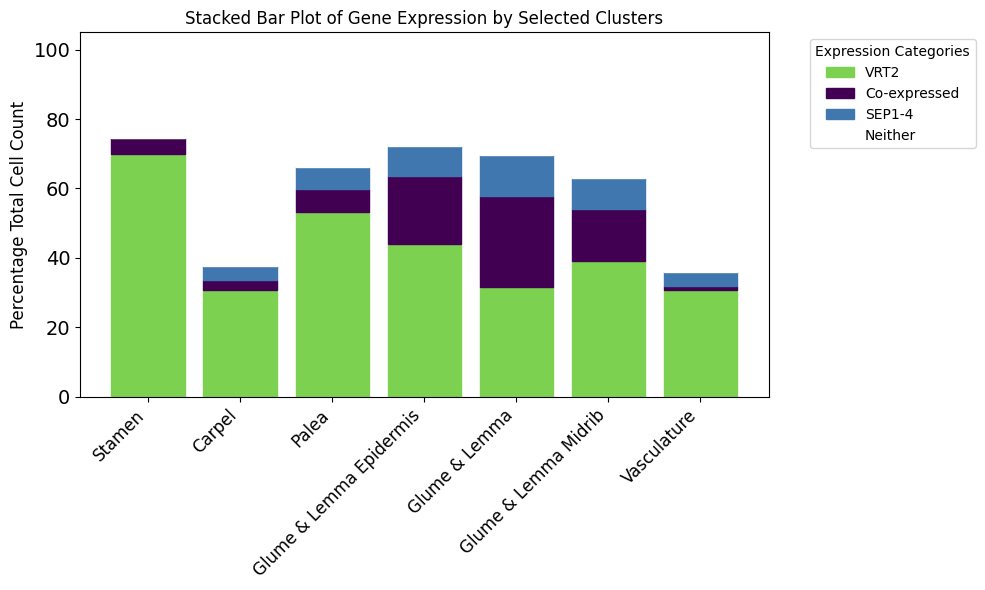

In [104]:
# Map of clusters to their descriptions
cluster_labels = {
    '3': 'Vasculature',
    '1': 'Glume & Lemma Epidermis',
    '2': 'Glume & Lemma',
    '8': 'Glume & Lemma Midrib',
    '15': 'Palea',
    '10': 'Stamen',
    '14': 'Stamen epidermis',
    '16': 'Carpel'
}

# Select and reorder the clusters
clusters_to_plot = ['10', '16', '15', '1', '2', '8', '3']
filtered_df = coexpression_df_VGN1a4.loc[clusters_to_plot]

# Data for the stacked bar plot
x = filtered_df.index  # Cluster numbers
vrt2 = filtered_df['percentage_vrt2']
co_expressed = filtered_df['percentage_coexpressing']
sep1_4 = filtered_df['percentage_sep1_4']
neither = filtered_df['percentage_neither']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(x, vrt2, label='VRT2', edgecolor='#7CD250', color='#7CD250')
plt.bar(x, co_expressed, bottom=vrt2, label='Co-expressed', edgecolor='#410052', color='#410052')
plt.bar(x, sep1_4, bottom=vrt2 + co_expressed, label='SEP1-4', edgecolor= '#4077AE', color='#4077AE')
plt.bar(x, neither, bottom=vrt2 + co_expressed + sep1_4, label='Neither', edgecolor='white', color='white')

plt.ylabel('Percentage Total Cell Count', size = 12)
plt.title('Stacked Bar Plot of Gene Expression by Selected Clusters')
plt.legend(title='Expression Categories', bbox_to_anchor=(1.05, 1), loc='upper left')

# Replace x-axis labels with cluster descriptions
xtick_labels = [cluster_labels[cluster] for cluster in clusters_to_plot]
plt.xticks(ticks=np.arange(len(x)), labels=xtick_labels, rotation=45, ha='right', size=12)
plt.yticks( size = 14)
plt.tight_layout()

# Show the plot

plt.savefig('VRT2analysis/VRTA2b_VRTSEP_bargraph.svg',  format='svg', facecolor='white', edgecolor='none', dpi=700)

plt.show()


saving the information that made these percentage plots into table for future reference </p>
(Supplementary Table 12)

In [67]:
coexpression_matrix_bothsamples = pd.concat([coexpression_df_VGN1a4, coexpression_df_VGN1a6], axis=0, ignore_index=False)
coexpression_matrix_bothsamples.to_csv("VRT2analysis/Figure4_PercentageCoExpression_VRTA2a_VRTA2b.csv", index=True)
coexpression_matrix_bothsamples

total_cells_count  co-expressed  VRT2  SEP1-4  neither  \
cluster                                                           
0                     1250            67   329     112      742   
1                      421            83   185      36      117   
2                      430           113   136      51      130   
3                      441             5   136      17      283   
4                      522            14   136      37      335   
5                      433            19   103      36      275   
6                      441            72   161      45      163   
7                      630            25   373       8      224   
8                      133            20    52      12       49   
9                        6             0     3       0        3   
10                      90             4    63       0       23   
11                     271             4    54      23      190   
12                      54             0    21       0       33   
13                      71            22    20       8       21   
14                      90             3    45       2       40   
15                     383            25   204      25      129   
16                     202             6    62       8      126   
17                      10             2     4       0        4   
0                     1171            10   134      81      946   
1                      336             6    19      80      231   
2                      270             3     6      81      180   
3                      635             5   199       4      427   
4                      632             0    26      77      529   
5                      248             1    30      10      207   
6                      247             5    29      50      163   
7                      233             0    11      14      208   
8                      157             3     3      35      116   
9                       18             0     8       0       10   
10                      40             0     3       3       34   
11                     282             0    19      20      243   
12                     137             0    16       1      120   
13                      49             0     2      15       32   
14                      35             0     1       1       33   
15                     134             1     4      15      114   
16                      78             0     3       1       74   
17                       1             0     0       0        1   

         percentage_coexpressing  percentage_vrt2  percentage_sep1_4  \
cluster                                                                
0                       5.360000        26.320000           8.960000   
1                      19.714964        43.942993           8.551069   
2                      26.279070        31.627907          11.860465   
3                       1.133787        30.839002           3.854875   
4                       2.681992        26.053640           7.088123   
5                       4.387991        23.787529           8.314088   
6                      16.326531        36.507937          10.204082   
7                       3.968254        59.206349           1.269841   
8                      15.037594        39.097744           9.022556   
9                       0.000000        50.000000           0.000000   
10                      4.444444        70.000000           0.000000   
11                      1.476015        19.926199           8.487085   
12                      0.000000        38.888889           0.000000   
13                     30.985915        28.169014          11.267606   
14                      3.333333        50.000000           2.222222   
15                      6.527415        53.263708           6.527415   
16                      2.970297        30.693069           3.960396   
17                     20.000000        40.000000           0.000000   
0                     